# 🌍 Air Quality Level Prediction - Pakistan Cities
## Complete Machine Learning Pipeline for Hackathon

**Cities:** Islamabad, Karachi, Lahore, Peshawar, Quetta

**Objective:** Predict daily AQI category (Good, Moderate, Unhealthy, Very Unhealthy) for the next 3 days

**Training Period:** Aug 2021 - Jun 2024 | **Testing Period:** Jul - Dec 2024

---
## 📦 Step 0: Import Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    f1_score,
    mean_squared_error,
    mean_absolute_error
)
import xgboost as xgb

# Model persistence
import joblib
import pickle

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"XGBoost version: {xgb.__version__}")

✅ All libraries imported successfully!
Pandas version: 2.2.3
NumPy version: 2.1.3
XGBoost version: 3.1.1


---
## 📁 Step 1: Load Training Data

Loading data from 5 Pakistani cities for training (Aug 2021 - Jun 2024)

In [2]:
def load_city_data(filepath, city_name, file_type='train'):
    """
    Load data for a specific city and add city column
    
    Parameters:
    -----------
    filepath : str
        Path to the data file
    city_name : str
        Name of the city
    file_type : str
        'train' or 'test' to indicate dataset type
    
    Returns:
    --------
    DataFrame with city column added
    """
    print(f"Loading {city_name} {file_type} data from: {filepath}")
    
    try:
        # Load based on file extension
        if filepath.endswith('.csv'):
            df = pd.read_csv(filepath)
        elif filepath.endswith('.xlsx'):
            df = pd.read_excel(filepath)
        else:
            raise ValueError(f"Unsupported file format for {filepath}")
        
        # Add city column
        df['city'] = city_name
        
        # Standardize datetime format
        if df['datetime'].dtype == 'object':
            # Try different date formats
            try:
                df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H:%M:%S')
            except:
                try:
                    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
                except:
                    df['datetime'] = pd.to_datetime(df['datetime'])
        else:
            df['datetime'] = pd.to_datetime(df['datetime'])
        
        print(f"  ✓ Loaded {len(df):,} records")
        print(f"  ✓ Date range: {df['datetime'].min()} to {df['datetime'].max()}")
        print(f"  ✓ Columns: {len(df.columns)}")
        
        return df
        
    except Exception as e:
        print(f"  ✗ Error loading {city_name}: {e}")
        return None

# Define file paths for training data
# IMPORTANT: Update these paths to match your actual file locations
train_files = {
    'Islamabad': 'islamabad_complete_data.xlsx',
    'Karachi': 'karachi_complete_data.xlsx',
    'Lahore': 'lahore_complete_data.xlsx',
    'Peshawar': 'peshawar_complete_data.csv',
    'Quetta': 'quetta_complete_data.csv'
}

# Load all training datasets
print("="*70)
print("LOADING TRAINING DATA")
print("="*70)

train_dataframes = []
for city, filepath in train_files.items():
    df = load_city_data(filepath, city, 'train')
    if df is not None:
        train_dataframes.append(df)
    print()

# Merge all training data
if len(train_dataframes) > 0:
    train_data = pd.concat(train_dataframes, ignore_index=True)
    print("="*70)
    print(f"✅ MERGED TRAINING DATA: {len(train_data):,} total records")
    print(f"   Cities: {train_data['city'].unique().tolist()}")
    print(f"   Date range: {train_data['datetime'].min()} to {train_data['datetime'].max()}")
    print(f"   Total days: {(train_data['datetime'].max() - train_data['datetime'].min()).days}")
    print("="*70)
else:
    print("❌ No training data loaded. Please check file paths.")

LOADING TRAINING DATA
Loading Islamabad train data from: islamabad_complete_data.xlsx
  ✓ Loaded 28,245 records
  ✓ Date range: 2021-08-24 00:00:00 to 2024-12-01 00:00:00
  ✓ Columns: 19

Loading Karachi train data from: karachi_complete_data.xlsx
  ✓ Loaded 28,221 records
  ✓ Date range: 2021-08-24 00:00:00 to 2024-12-01 00:00:00
  ✓ Columns: 19

Loading Lahore train data from: lahore_complete_data.xlsx
  ✓ Loaded 28,269 records
  ✓ Date range: 2021-08-24 00:00:00 to 2024-12-01 00:00:00
  ✓ Columns: 19

Loading Peshawar train data from: peshawar_complete_data.csv
  ✗ Error loading Peshawar: time data "1/9/2021 0:00" doesn't match format "%d/%m/%Y %H:%M:%S", at position 192. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to us

### Training Data Summary

In [3]:
# Display first few rows
print("First 5 rows of merged training data:")
display(train_data.head())

print("\nDataset Info:")
print(train_data.info())

print("\nRecords per city:")
print(train_data['city'].value_counts())

First 5 rows of merged training data:


,datetime,main.aqi,components.co,components.no,components.no2,components.o3,components.so2,components.pm2_5,components.pm10,components.nh3,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,surface_pressure,wind_speed_10m,wind_direction_10m,shortwave_radiation,city
0,2021-08-24 00:00:00,5,1228.33,0.00,27.76,40.41,6.02,66.96,87.07,14.69,29.7,55,19.7,0.0,943.4,10.5,74,0,Islamabad
1,2021-08-24 01:00:00,5,1134.87,0.00,24.33,46.49,6.20,64.50,82.37,14.57,29.4,56,19.7,0.0,943.2,10.8,92,0,Islamabad
2,2021-08-24 02:00:00,5,1361.85,0.94,39.41,30.76,6.91,64.21,80.38,16.21,28.9,58,19.8,0.0,943.0,10.1,107,0,Islamabad
3,2021-08-24 03:00:00,5,1682.28,8.38,51.41,27.18,9.06,64.75,79.55,17.73,28.4,60,19.8,0.0,942.8,10.5,106,0,Islamabad
4,2021-08-24 04:00:00,5,1054.76,3.07,27.08,91.55,21.70,59.86,71.18,13.30,28.1,62,20.1,0.0,942.9,9.4,97,0,Islamabad



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84735 entries, 0 to 84734
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   datetime              84735 non-null  datetime64[ns]
 1   main.aqi              84735 non-null  int64         
 2   components.co         84735 non-null  float64       
 3   components.no         84735 non-null  float64       
 4   components.no2        84735 non-null  float64       
 5   components.o3         84735 non-null  float64       
 6   components.so2        84735 non-null  float64       
 7   components.pm2_5      84735 non-null  float64       
 8   components.pm10       84735 non-null  float64       
 9   components.nh3        84735 non-null  float64       
 10  temperature_2m        84735 non-null  float64       
 11  relative_humidity_2m  84735 non-null  int64         
 12  dew_point_2m          84735 non-null  float64       
 13  p

---
## 🧹 Step 2: Data Cleaning and Preprocessing

Handle missing values, remove duplicates, and prepare data for analysis

In [4]:
def clean_dataset(df, dataset_name='Dataset'):
    """
    Clean the dataset by handling missing values and duplicates
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe to clean
    dataset_name : str
        Name of dataset for logging
    
    Returns:
    --------
    Cleaned DataFrame
    """
    print(f"\n{'='*70}")
    print(f"CLEANING {dataset_name}")
    print(f"{'='*70}")
    
    initial_rows = len(df)
    print(f"Initial rows: {initial_rows:,}")
    
    # Check missing values before cleaning
    print("\nMissing values before cleaning:")
    missing_before = df.isnull().sum()
    missing_before = missing_before[missing_before > 0]
    if len(missing_before) > 0:
        print(missing_before)
    else:
        print("No missing values found!")
    
    # Remove duplicates based on datetime and city
    df = df.drop_duplicates(subset=['datetime', 'city'], keep='first')
    duplicates_removed = initial_rows - len(df)
    print(f"\n✓ Removed {duplicates_removed:,} duplicate records")
    
    # Sort by city and datetime
    df = df.sort_values(['city', 'datetime']).reset_index(drop=True)
    print("✓ Sorted by city and datetime")
    
    # Handle missing values city by city
    print("\n✓ Handling missing values per city...")
    for city in df['city'].unique():
        city_mask = df['city'] == city
        city_missing_before = df[city_mask].isnull().sum().sum()
        
        # Forward fill then backward fill for each column
        for col in df.columns:
            if col not in ['datetime', 'city']:
                df.loc[city_mask, col] = df.loc[city_mask, col].fillna(method='ffill').fillna(method='bfill')
        
        city_missing_after = df[city_mask].isnull().sum().sum()
        print(f"  {city}: {city_missing_before} → {city_missing_after} missing values")
    
    # Drop rows with critical missing values (PM2.5 and AQI)
    critical_cols = ['components.pm2_5', 'main.aqi']
    rows_before_critical = len(df)
    df = df.dropna(subset=critical_cols)
    rows_dropped = rows_before_critical - len(df)
    
    if rows_dropped > 0:
        print(f"\n✓ Dropped {rows_dropped:,} rows with missing PM2.5 or AQI")
    
    # Final check
    print("\nMissing values after cleaning:")
    missing_after = df.isnull().sum()
    missing_after = missing_after[missing_after > 0]
    if len(missing_after) > 0:
        print(missing_after)
    else:
        print("✅ No missing values remaining!")
    
    print(f"\nFinal rows: {len(df):,} (lost {initial_rows - len(df):,} rows)")
    print(f"{'='*70}\n")
    
    return df

# Clean training data
train_data_cleaned = clean_dataset(train_data, 'TRAINING DATA')


CLEANING TRAINING DATA
Initial rows: 84,735

Missing values before cleaning:
No missing values found!

✓ Removed 0 duplicate records
✓ Sorted by city and datetime

✓ Handling missing values per city...
  Islamabad: 0 → 0 missing values
  Karachi: 0 → 0 missing values
  Lahore: 0 → 0 missing values

Missing values after cleaning:
✅ No missing values remaining!

Final rows: 84,735 (lost 0 rows)



### Resample to Daily Averages

In [5]:
def resample_to_daily(df, dataset_name='Dataset'):
    """
    Resample hourly data to daily averages
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe with hourly data
    dataset_name : str
        Name for logging
    
    Returns:
    --------
    DataFrame with daily averages
    """
    print(f"\nResampling {dataset_name} to daily averages...")
    
    # Create date column
    df['date'] = df['datetime'].dt.date
    
    # Get numeric columns for aggregation
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Group by city and date, calculate mean
    daily_df = df.groupby(['city', 'date'])[numeric_cols].mean().reset_index()
    
    # Convert date back to datetime
    daily_df['date'] = pd.to_datetime(daily_df['date'])
    
    print(f"✓ Resampled from {len(df):,} hourly records to {len(daily_df):,} daily records")
    print(f"\nDaily records per city:")
    for city in daily_df['city'].unique():
        count = len(daily_df[daily_df['city'] == city])
        date_range = daily_df[daily_df['city'] == city]['date']
        print(f"  {city}: {count} days ({date_range.min().date()} to {date_range.max().date()})")
    
    return daily_df

# Resample training data to daily
train_daily = resample_to_daily(train_data_cleaned, 'TRAINING DATA')

print("\nDaily training data shape:", train_daily.shape)
display(train_daily.head())


Resampling TRAINING DATA to daily averages...
✓ Resampled from 84,735 hourly records to 3,575 daily records

Daily records per city:
  Islamabad: 1192 days (2021-08-24 to 2024-12-01)
  Karachi: 1191 days (2021-08-24 to 2024-12-01)
  Lahore: 1192 days (2021-08-24 to 2024-12-01)

Daily training data shape: (3575, 19)


,city,date,main.aqi,components.co,components.no,components.no2,components.o3,components.so2,components.pm2_5,components.pm10,components.nh3,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,surface_pressure,wind_speed_10m,wind_direction_10m,shortwave_radiation
0,Islamabad,2021-08-24,5.000000,2404.093750,31.675000,57.764583,81.752083,12.857917,77.960000,94.144167,18.377083,32.170833,50.166667,19.916667,0.091667,942.062500,9.008333,155.375000,281.291667
1,Islamabad,2021-08-25,5.000000,1643.339583,5.290417,48.724583,104.473333,15.423333,83.923750,107.664583,14.841250,33.245833,44.083333,18.904167,0.000000,939.866667,9.666667,123.208333,292.416667
2,Islamabad,2021-08-26,5.000000,791.629583,0.337500,14.923750,123.592083,11.250417,91.031667,199.967500,10.597083,33.450000,41.375000,18.095833,0.000000,938.787500,10.175000,126.458333,293.166667
3,Islamabad,2021-08-27,5.000000,822.782083,0.653750,20.237500,133.127917,14.491250,92.265833,226.200417,9.554167,32.800000,46.375000,19.158333,0.125000,940.891667,10.491667,132.250000,290.916667
4,Islamabad,2021-08-28,4.958333,1377.423750,0.912083,43.450417,105.187500,18.569167,73.255833,124.433750,8.193750,30.408333,53.375000,19.304167,0.266667,942.058333,12.737500,81.041667,282.875000


---
## 📊 Step 3: Exploratory Data Analysis (EDA)

Visualize and understand the data patterns

### 3.1 Basic Statistics

In [6]:
print("="*70)
print("BASIC STATISTICS")
print("="*70)

# Overall statistics
print("\nDescriptive Statistics:")
display(train_daily.describe())

# Statistics per city
print("\nPM2.5 Statistics by City:")
pm25_stats = train_daily.groupby('city')['components.pm2_5'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('25%', lambda x: x.quantile(0.25)),
    ('50%', 'median'),
    ('75%', lambda x: x.quantile(0.75)),
    ('max', 'max')
]).round(2)
display(pm25_stats)

BASIC STATISTICS

Descriptive Statistics:


,date,main.aqi,components.co,components.no,components.no2,components.o3,components.so2,components.pm2_5,components.pm10,components.nh3,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,surface_pressure,wind_speed_10m,wind_direction_10m,shortwave_radiation
count,3575,3575.000000,3575.000000,3575.000000,3575.000000,3575.000000,3575.000000,3575.000000,3575.000000,3575.000000,3575.000000,3575.000000,3575.000000,3575.000000,3575.000000,3575.000000,3575.000000,3575.000000
mean,2023-04-13 14:17:09.146853376,4.313962,2455.465351,26.618792,55.117686,61.285602,16.468506,134.075257,178.335988,23.399953,24.498456,61.119965,15.095250,0.076865,980.328722,6.044742,204.654217,209.601226
min,2021-08-24 00:00:00,1.000000,199.159167,0.000000,1.050000,0.000000,0.991250,3.202500,7.335000,0.000000,3.600000,5.416667,-13.204167,0.000000,935.850000,1.025417,5.000000,0.000000
25%,2022-06-17 12:00:00,3.875000,940.303750,1.493958,23.570833,38.246250,8.566875,41.376667,73.930625,7.811042,19.616667,50.333333,8.891667,0.000000,955.250000,3.960851,142.479167,168.208333
50%,2023-04-14 00:00:00,4.708333,1960.158750,12.572500,50.552917,57.914583,14.410417,89.570000,128.578750,19.075833,26.887500,65.666667,15.291667,0.000000,982.825000,5.662500,218.916667,215.083333
75%,2024-02-07 00:00:00,5.000000,3444.949583,38.152083,77.968958,80.600000,22.157917,172.721458,226.885417,33.888333,29.766667,74.291667,22.714583,0.008333,1002.666667,7.779167,261.666667,255.416667
max,2024-12-01 00:00:00,5.000000,14210.383750,284.155417,262.085417,179.857917,81.817500,994.880417,1071.564167,139.178333,38.875000,100.000000,29.000000,11.850000,1020.720833,24.758333,360.000000,360.333333
std,NaN,0.850227,1975.843108,35.476204,39.208341,29.647909,11.622899,134.922126,152.215757,20.387907,7.007587,18.070531,8.018014,0.310175,24.527100,2.891307,70.960186,66.331115



PM2.5 Statistics by City:


,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
Islamabad,1192,122.23,98.23,7.72,53.41,92.09,155.24,544.99
Karachi,1191,81.53,93.41,3.20,20.92,39.14,110.51,617.03
Lahore,1192,198.42,170.92,10.82,77.36,133.27,270.83,994.88


### 3.2 PM2.5 Trends Over Time

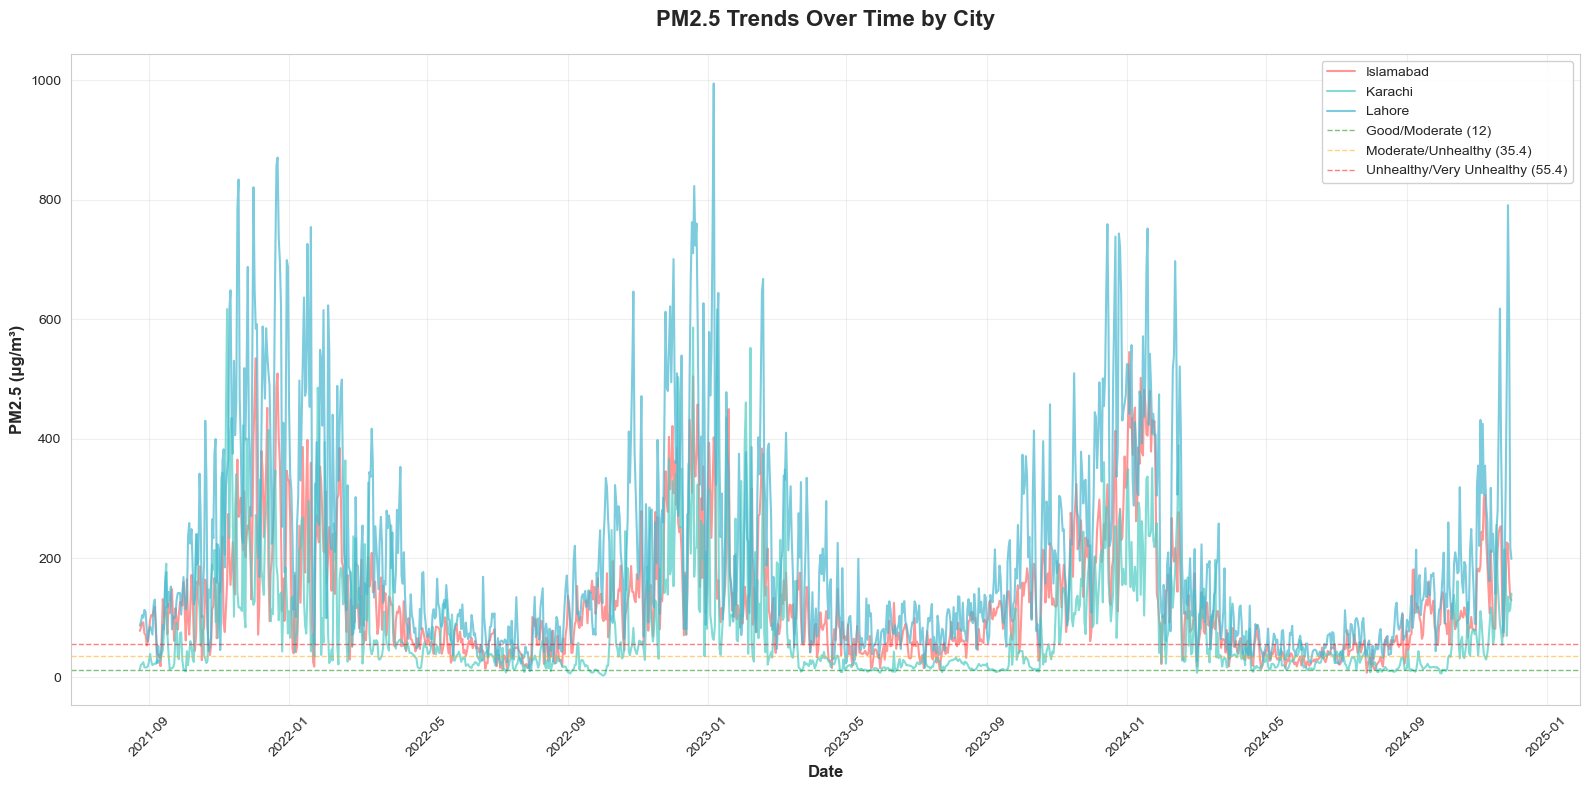

✓ Saved: pm25_trends_over_time.png


In [7]:
# PM2.5 trends for all cities
fig, ax = plt.subplots(figsize=(16, 8))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
for idx, city in enumerate(train_daily['city'].unique()):
    city_data = train_daily[train_daily['city'] == city].sort_values('date')
    ax.plot(city_data['date'], city_data['components.pm2_5'], 
            label=city, alpha=0.7, linewidth=1.5, color=colors[idx % len(colors)])

# Add AQI threshold lines
ax.axhline(y=12, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Good/Moderate (12)')
ax.axhline(y=35.4, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Moderate/Unhealthy (35.4)')
ax.axhline(y=55.4, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Unhealthy/Very Unhealthy (55.4)')

ax.set_title('PM2.5 Trends Over Time by City', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('PM2.5 (μg/m³)', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('pm25_trends_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: pm25_trends_over_time.png")

### 3.3 AQI Distribution by City

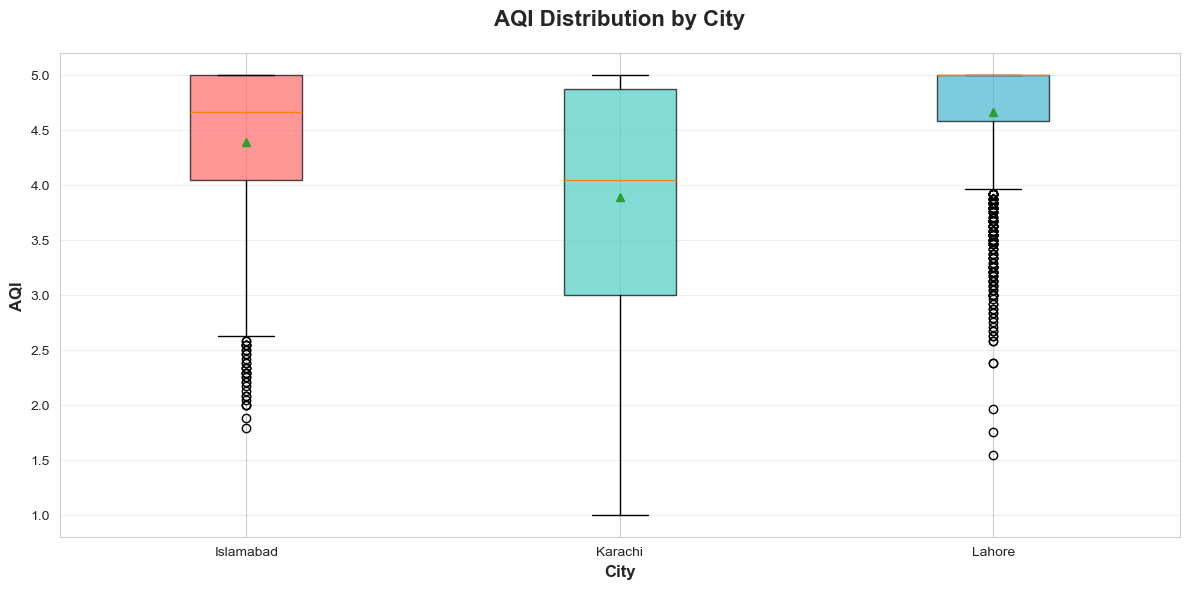

✓ Saved: aqi_distribution_by_city.png


In [8]:
# Box plot of AQI by city
fig, ax = plt.subplots(figsize=(12, 6))

cities = train_daily['city'].unique()
data_to_plot = [train_daily[train_daily['city'] == city]['main.aqi'].values for city in cities]

bp = ax.boxplot(data_to_plot, labels=cities, patch_artist=True, showmeans=True)

# Color the boxes
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_title('AQI Distribution by City', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('City', fontsize=12, fontweight='bold')
ax.set_ylabel('AQI', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('aqi_distribution_by_city.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: aqi_distribution_by_city.png")

### 3.4 Correlation Heatmap

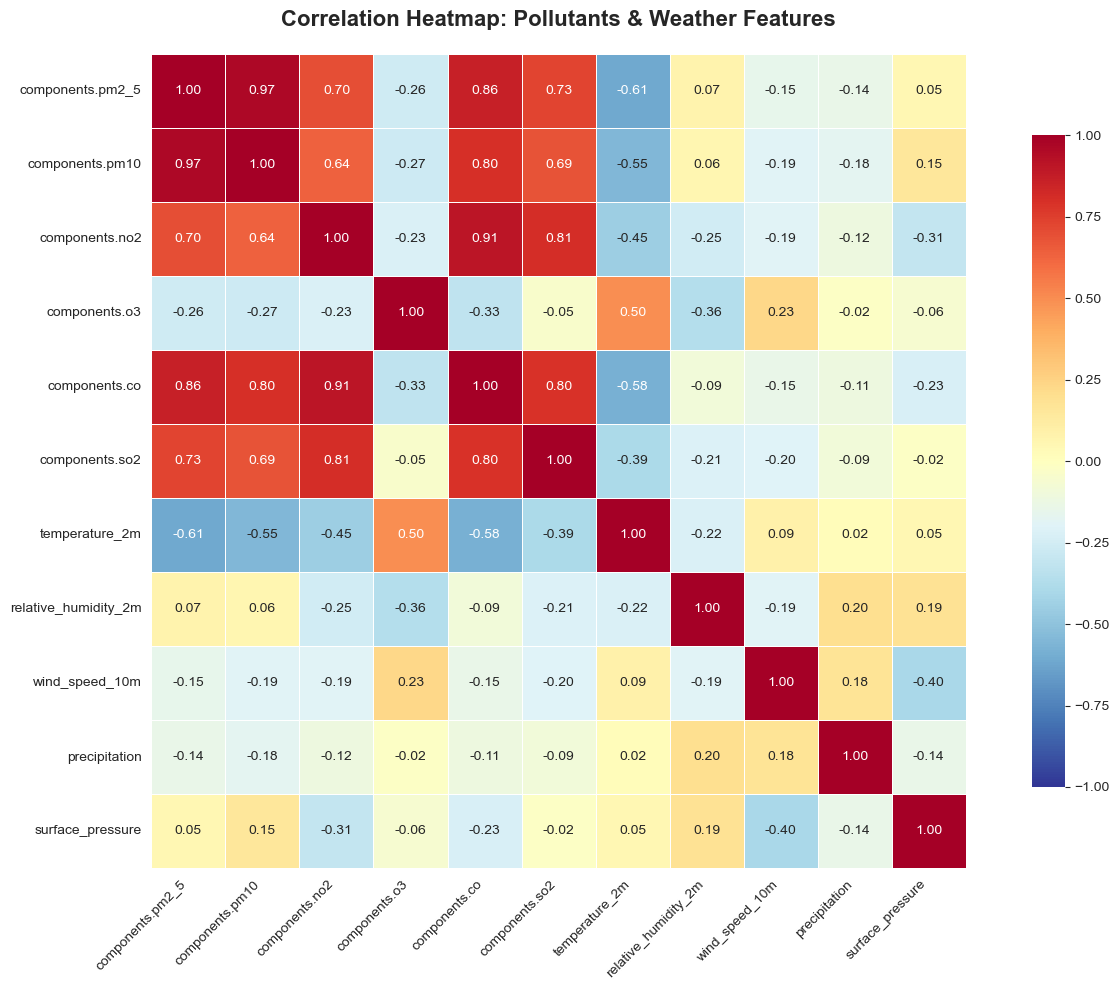

✓ Saved: correlation_heatmap.png

Strongest correlations with PM2.5:
components.pm10         0.968651
components.co           0.859426
components.so2          0.731841
components.no2          0.698088
relative_humidity_2m    0.070931
Name: components.pm2_5, dtype: float64


In [9]:
# Select pollutant and weather columns for correlation
corr_cols = [
    'components.pm2_5', 'components.pm10', 'components.no2',
    'components.o3', 'components.co', 'components.so2',
    'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m',
    'precipitation', 'surface_pressure'
]

# Calculate correlation matrix
correlation_matrix = train_daily[corr_cols].corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r',
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, center=0, ax=ax)

ax.set_title('Correlation Heatmap: Pollutants & Weather Features', 
             fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: correlation_heatmap.png")

# Print strongest correlations with PM2.5
print("\nStrongest correlations with PM2.5:")
pm25_corr = correlation_matrix['components.pm2_5'].sort_values(ascending=False)
print(pm25_corr[pm25_corr.index != 'components.pm2_5'].head(5))

### 3.5 PM2.5 Distribution per City

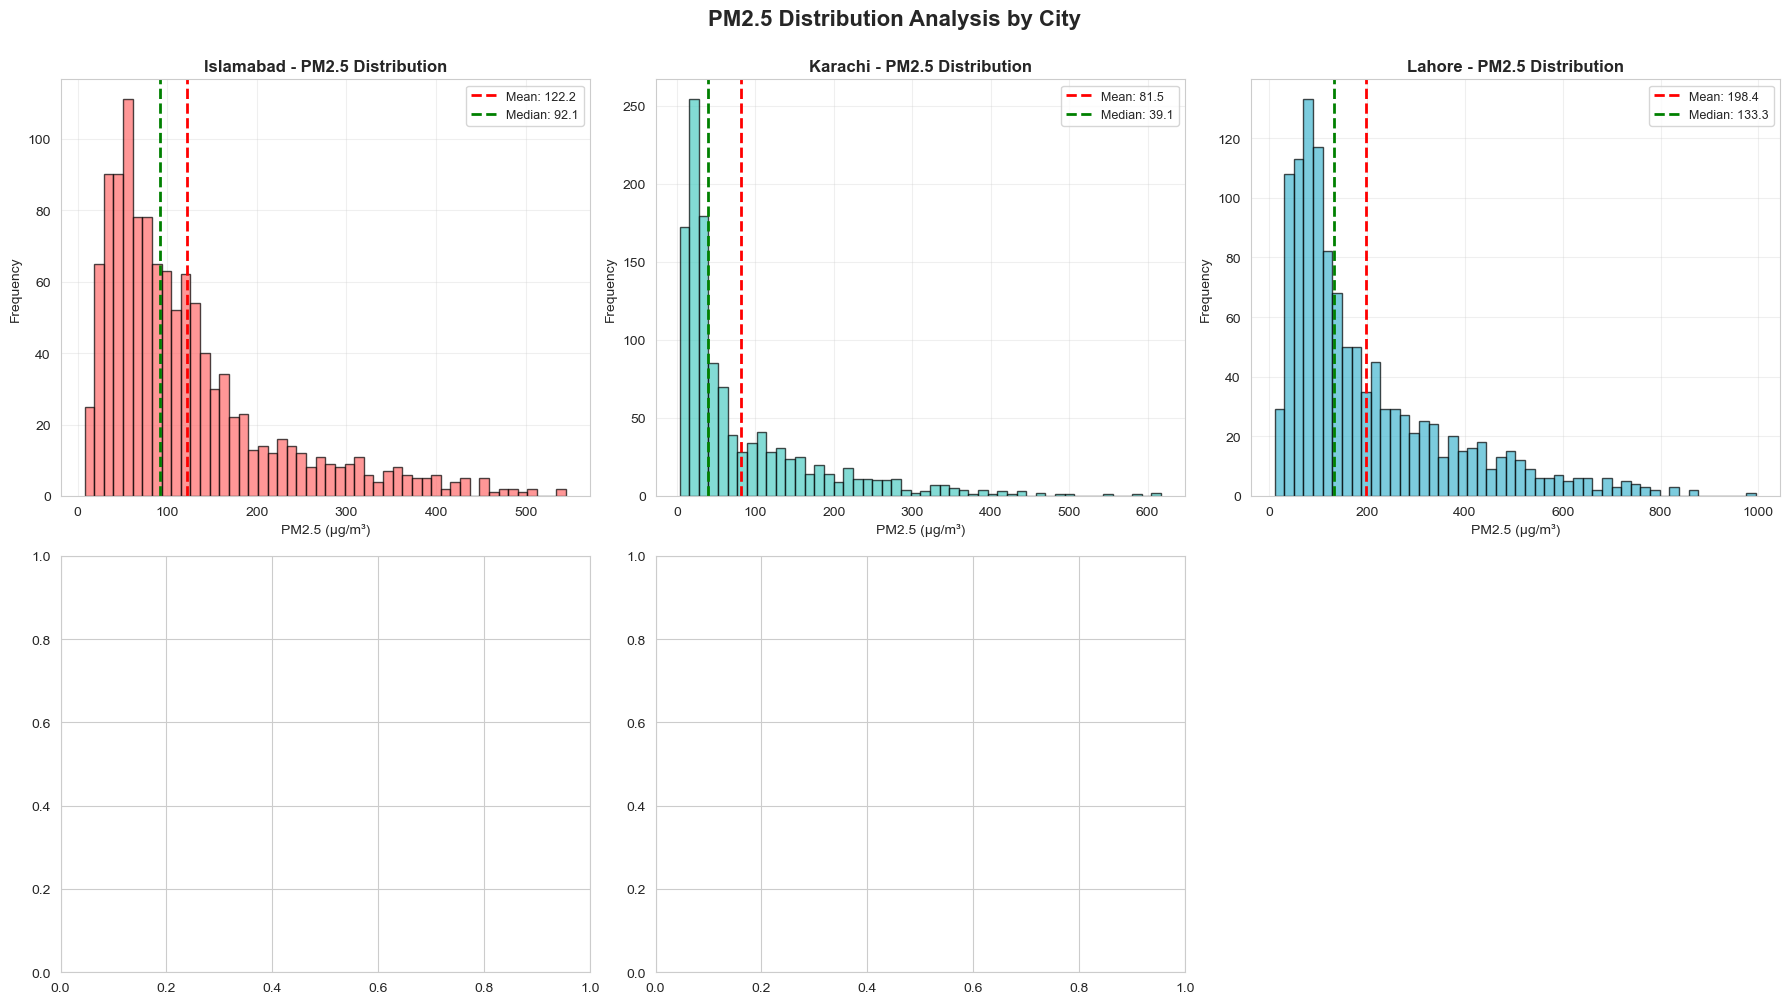

✓ Saved: pm25_distributions_per_city.png


In [10]:
# Histograms for each city
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
cities = train_daily['city'].unique()

for idx, city in enumerate(cities):
    city_data = train_daily[train_daily['city'] == city]['components.pm2_5']
    
    axes[idx].hist(city_data, bins=50, edgecolor='black', alpha=0.7, color=colors[idx])
    axes[idx].set_title(f'{city} - PM2.5 Distribution', fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('PM2.5 (μg/m³)', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    
    # Add mean and median lines
    axes[idx].axvline(city_data.mean(), color='red', linestyle='--', 
                     linewidth=2, label=f'Mean: {city_data.mean():.1f}')
    axes[idx].axvline(city_data.median(), color='green', linestyle='--', 
                     linewidth=2, label=f'Median: {city_data.median():.1f}')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

# Hide extra subplot
axes[-1].axis('off')

plt.suptitle('PM2.5 Distribution Analysis by City', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('pm25_distributions_per_city.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: pm25_distributions_per_city.png")

### 3.6 Outlier Detection

In [11]:
# Detect outliers using IQR method
print("="*70)
print("OUTLIER DETECTION (PM2.5)")
print("="*70)

for city in train_daily['city'].unique():
    city_pm25 = train_daily[train_daily['city'] == city]['components.pm2_5']
    
    Q1 = city_pm25.quantile(0.25)
    Q3 = city_pm25.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = city_pm25[(city_pm25 < lower_bound) | (city_pm25 > upper_bound)]
    outlier_pct = (len(outliers) / len(city_pm25)) * 100
    
    print(f"\n{city}:")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  Outliers: {len(outliers)} ({outlier_pct:.1f}%)")
    if len(outliers) > 0:
        print(f"  Max outlier: {outliers.max():.2f}")

print("\n" + "="*70)

OUTLIER DETECTION (PM2.5)

Islamabad:
  Q1: 53.41, Q3: 155.24, IQR: 101.83
  Bounds: [-99.33, 307.98]
  Outliers: 85 (7.1%)
  Max outlier: 544.99

Karachi:
  Q1: 20.92, Q3: 110.51, IQR: 89.59
  Bounds: [-113.45, 244.89]
  Outliers: 88 (7.4%)
  Max outlier: 617.03

Lahore:
  Q1: 77.36, Q3: 270.83, IQR: 193.47
  Bounds: [-212.86, 561.04]
  Outliers: 61 (5.1%)
  Max outlier: 994.88



---
## 🔧 Step 4: Feature Engineering

Create lag features, rolling averages, and derived features for better predictions

In [12]:
def create_aqi_category(pm25_value):
    """
    Convert PM2.5 value to AQI category based on EPA standards
    
    AQI Categories:
    - Good: PM2.5 ≤ 12 μg/m³
    - Moderate: 12 < PM2.5 ≤ 35.4 μg/m³
    - Unhealthy: 35.4 < PM2.5 ≤ 55.4 μg/m³
    - Very Unhealthy: PM2.5 > 55.4 μg/m³
    """
    if pm25_value <= 12:
        return 'Good'
    elif pm25_value <= 35.4:
        return 'Moderate'
    elif pm25_value <= 55.4:
        return 'Unhealthy'
    else:
        return 'Very Unhealthy'

def engineer_features(df, is_training=True):
    """
    Create comprehensive features for ML model
    
    Features created:
    1. Lag features: pm2_5_lag1, pm2_5_lag3, pm2_5_lag7
    2. Rolling averages: pm2_5_roll3, pm2_5_roll7, pm2_5_roll14
    3. Pollution ratios: pm2_5_pm10_ratio, no2_co_ratio
    4. Datetime features: day, month, weekday, quarter, day_of_year
    5. Target: aqi_category
    """
    print(f"\n{'='*70}")
    print(f"FEATURE ENGINEERING ({'TRAINING' if is_training else 'TESTING'} DATA)")
    print(f"{'='*70}")
    
    df = df.copy()
    df = df.sort_values(['city', 'date']).reset_index(drop=True)
    
    print(f"\nInitial shape: {df.shape}")
    
    # Create AQI category from PM2.5
    df['aqi_category'] = df['components.pm2_5'].apply(create_aqi_category)
    print("✓ Created target: aqi_category")
    
    # Create features for each city separately (to avoid data leakage)
    print("\n✓ Creating lag and rolling features per city...")
    
    for city in df['city'].unique():
        city_mask = df['city'] == city
        
        # Lag features (previous days' values)
        df.loc[city_mask, 'pm2_5_lag1'] = df.loc[city_mask, 'components.pm2_5'].shift(1)
        df.loc[city_mask, 'pm2_5_lag3'] = df.loc[city_mask, 'components.pm2_5'].shift(3)
        df.loc[city_mask, 'pm2_5_lag7'] = df.loc[city_mask, 'components.pm2_5'].shift(7)
        
        # Rolling averages (smoothed trends)
        df.loc[city_mask, 'pm2_5_roll3'] = df.loc[city_mask, 'components.pm2_5'].rolling(
            window=3, min_periods=1).mean()
        df.loc[city_mask, 'pm2_5_roll7'] = df.loc[city_mask, 'components.pm2_5'].rolling(
            window=7, min_periods=1).mean()
        df.loc[city_mask, 'pm2_5_roll14'] = df.loc[city_mask, 'components.pm2_5'].rolling(
            window=14, min_periods=1).mean()
        
        print(f"  {city}: ✓ Lag and rolling features created")
    
    # Pollution ratios
    df['pm2_5_pm10_ratio'] = df['components.pm2_5'] / (df['components.pm10'] + 0.001)
    df['no2_co_ratio'] = df['components.no2'] / (df['components.co'] + 0.001)
    print("\n✓ Created pollution ratios")
    
    # Datetime features
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['day_of_year'] = df['date'].dt.dayofyear
    print("✓ Created datetime features")
    
    # Season feature
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Autumn'
    
    df['season'] = df['month'].apply(get_season)
    print("✓ Created season feature")
    
    print(f"\nFinal shape: {df.shape}")
    print(f"New features added: {df.shape[1] - 19}")
    
    # Display AQI category distribution
    print("\nAQI Category Distribution:")
    print(df['aqi_category'].value_counts().sort_index())
    print(f"\n{'='*70}\n")
    
    return df

# Apply feature engineering to training data
train_features = engineer_features(train_daily, is_training=True)

# Display sample of features
print("\nSample of engineered features:")
sample_cols = ['date', 'city', 'components.pm2_5', 'pm2_5_lag1', 'pm2_5_lag3', 
               'pm2_5_roll3', 'pm2_5_roll7', 'aqi_category']
display(train_features[sample_cols].head(15))


FEATURE ENGINEERING (TRAINING DATA)

Initial shape: (3575, 19)
✓ Created target: aqi_category

✓ Creating lag and rolling features per city...
  Islamabad: ✓ Lag and rolling features created
  Karachi: ✓ Lag and rolling features created
  Lahore: ✓ Lag and rolling features created

✓ Created pollution ratios
✓ Created datetime features
✓ Created season feature

Final shape: (3575, 34)
New features added: 15

AQI Category Distribution:
aqi_category
Good                71
Moderate           668
Unhealthy          466
Very Unhealthy    2370
Name: count, dtype: int64



Sample of engineered features:


,date,city,components.pm2_5,pm2_5_lag1,pm2_5_lag3,pm2_5_roll3,pm2_5_roll7,aqi_category
0,2021-08-24,Islamabad,77.960000,NaN,NaN,77.960000,77.960000,Very Unhealthy
1,2021-08-25,Islamabad,83.923750,77.960000,NaN,80.941875,80.941875,Very Unhealthy
2,2021-08-26,Islamabad,91.031667,83.923750,NaN,84.305139,84.305139,Very Unhealthy
3,2021-08-27,Islamabad,92.265833,91.031667,77.960000,89.073750,86.295312,Very Unhealthy
4,2021-08-28,Islamabad,73.255833,92.265833,83.923750,85.517778,83.687417,Very Unhealthy
5,2021-08-29,Islamabad,71.549167,73.255833,91.031667,79.023611,81.664375,Very Unhealthy
6,2021-08-30,Islamabad,53.477083,71.549167,92.265833,66.094028,77.637619,Unhealthy
7,2021-08-31,Islamabad,60.987500,53.477083,73.255833,62.004583,75.212976,Very Unhealthy
8,2021-09-01,Islamabad,80.405417,60.987500,71.549167,64.956667,74.710357,Very Unhealthy
9,2021-09-02,Islamabad,96.475833,80.405417,53.477083,79.289583,75.488095,Very Unhealthy


### Remove rows with NaN from lag features

In [13]:
# Drop rows with NaN (created by lag features)
print(f"Rows before dropping NaN: {len(train_features):,}")
train_features = train_features.dropna()
print(f"Rows after dropping NaN: {len(train_features):,}")
print(f"Rows lost: {len(engineer_features(train_daily, is_training=True)) - len(train_features):,}")

print("\n✓ Ready for model training!")

Rows before dropping NaN: 3,575
Rows after dropping NaN: 3,554

FEATURE ENGINEERING (TRAINING DATA)

Initial shape: (3575, 19)
✓ Created target: aqi_category

✓ Creating lag and rolling features per city...
  Islamabad: ✓ Lag and rolling features created
  Karachi: ✓ Lag and rolling features created
  Lahore: ✓ Lag and rolling features created

✓ Created pollution ratios
✓ Created datetime features
✓ Created season feature

Final shape: (3575, 34)
New features added: 15

AQI Category Distribution:
aqi_category
Good                71
Moderate           668
Unhealthy          466
Very Unhealthy    2370
Name: count, dtype: int64


Rows lost: 21

✓ Ready for model training!


---
## 🤖 Step 5: Model Preparation

Prepare features and labels for training

In [14]:
# Define feature columns for model training
feature_columns = [
    # Lag features (past PM2.5 values)
    'pm2_5_lag1', 'pm2_5_lag3', 'pm2_5_lag7',
    
    # Rolling averages (trends)
    'pm2_5_roll3', 'pm2_5_roll7', 'pm2_5_roll14',
    
    # Other pollutants
    'components.pm10', 'components.no2', 'components.o3',
    'components.co', 'components.so2', 'components.nh3',
    
    # Weather features
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
    'precipitation', 'surface_pressure', 'wind_speed_10m', 
    'wind_direction_10m', 'shortwave_radiation',
    
    # Derived features
    'pm2_5_pm10_ratio', 'no2_co_ratio',
    
    # Temporal features
    'day', 'month', 'weekday', 'quarter', 'day_of_year'
]

print(f"Total features for training: {len(feature_columns)}")
print("\nFeature categories:")
print(f"  - Lag features: 3")
print(f"  - Rolling features: 3")
print(f"  - Pollutants: 6")
print(f"  - Weather: 8")
print(f"  - Derived: 2")
print(f"  - Temporal: 5")

Total features for training: 27

Feature categories:
  - Lag features: 3
  - Rolling features: 3
  - Pollutants: 6
  - Weather: 8
  - Derived: 2
  - Temporal: 5


In [15]:
# Encode city as numeric feature
city_encoder = LabelEncoder()
train_features['city_encoded'] = city_encoder.fit_transform(train_features['city'])
feature_columns.append('city_encoded')

print("City encoding:")
for city, code in zip(city_encoder.classes_, range(len(city_encoder.classes_))):
    print(f"  {city}: {code}")

# Encode target variable (AQI category)
label_encoder = LabelEncoder()
train_features['aqi_category_encoded'] = label_encoder.fit_transform(train_features['aqi_category'])

print("\nAQI Category encoding:")
for category, code in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"  {code}: {category}")

# Save encoders for later use
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(city_encoder, 'city_encoder.pkl')
joblib.dump(feature_columns, 'feature_columns.pkl')

print("\n✓ Encoders saved!")

City encoding:
  Islamabad: 0
  Karachi: 1
  Lahore: 2

AQI Category encoding:
  0: Good
  1: Moderate
  2: Unhealthy
  3: Very Unhealthy

✓ Encoders saved!


### Time-Series Aware Train-Validation Split

In [16]:
# Time-series split: train on older data, validate on recent data
split_date = pd.to_datetime('2024-01-01')

train_set = train_features[train_features['date'] < split_date]
val_set = train_features[train_features['date'] >= split_date]

print("="*70)
print("TRAIN-VALIDATION SPLIT")
print("="*70)

print(f"\nTraining set:")
print(f"  Size: {len(train_set):,} samples")
print(f"  Date range: {train_set['date'].min().date()} to {train_set['date'].max().date()}")
print(f"  Cities: {train_set['city'].nunique()}")

print(f"\nValidation set:")
print(f"  Size: {len(val_set):,} samples")
print(f"  Date range: {val_set['date'].min().date()} to {val_set['date'].max().date()}")
print(f"  Cities: {val_set['city'].nunique()}")

print(f"\nSplit ratio: {len(train_set)/len(train_features)*100:.1f}% train, {len(val_set)/len(train_features)*100:.1f}% validation")
print("="*70)

# Prepare X and y for training and validation
X_train = train_set[feature_columns]
y_train = train_set['aqi_category_encoded']

X_val = val_set[feature_columns]
y_val = val_set['aqi_category_encoded']

print(f"\nX_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

TRAIN-VALIDATION SPLIT

Training set:
  Size: 2,547 samples
  Date range: 2021-08-31 to 2023-12-31
  Cities: 3

Validation set:
  Size: 1,007 samples
  Date range: 2024-01-01 to 2024-12-01
  Cities: 3

Split ratio: 71.7% train, 28.3% validation

X_train shape: (2547, 28)
X_val shape: (1007, 28)
y_train shape: (2547,)
y_val shape: (1007,)


---
## 🎯 Step 6: Model Training

Train Random Forest and XGBoost models

### 6.1 Random Forest Classifier

In [17]:
print("="*70)
print("TRAINING RANDOM FOREST CLASSIFIER")
print("="*70)

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,        # Number of trees
    max_depth=20,            # Maximum depth of trees
    min_samples_split=5,     # Minimum samples to split node
    min_samples_leaf=2,      # Minimum samples in leaf
    random_state=42,         # For reproducibility
    n_jobs=-1,               # Use all CPU cores
    verbose=1                # Show progress
)

print("\nModel parameters:")
print(f"  n_estimators: {rf_model.n_estimators}")
print(f"  max_depth: {rf_model.max_depth}")
print(f"  min_samples_split: {rf_model.min_samples_split}")
print(f"  min_samples_leaf: {rf_model.min_samples_leaf}")

print("\nTraining...")
import time
start_time = time.time()

rf_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"\n✓ Training completed in {training_time:.2f} seconds")
print("="*70)

TRAINING RANDOM FOREST CLASSIFIER

Model parameters:
  n_estimators: 200
  max_depth: 20
  min_samples_split: 5
  min_samples_leaf: 2

Training...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s



✓ Training completed in 0.85 seconds


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.6s finished


### 6.2 XGBoost Classifier

In [18]:
print("="*70)
print("TRAINING XGBOOST CLASSIFIER")
print("="*70)

# Initialize XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=200,        # Number of boosting rounds
    max_depth=10,            # Maximum tree depth
    learning_rate=0.1,       # Step size shrinkage
    subsample=0.8,           # Subsample ratio of training instances
    colsample_bytree=0.8,    # Subsample ratio of columns
    random_state=42,         # For reproducibility
    n_jobs=-1,               # Use all CPU cores
    eval_metric='mlogloss'   # Multi-class log loss
)

print("\nModel parameters:")
print(f"  n_estimators: {xgb_model.n_estimators}")
print(f"  max_depth: {xgb_model.max_depth}")
print(f"  learning_rate: {xgb_model.learning_rate}")
print(f"  subsample: {xgb_model.subsample}")
print(f"  colsample_bytree: {xgb_model.colsample_bytree}")

print("\nTraining with early stopping...")
start_time = time.time()

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50  # Print every 50 rounds
)

training_time = time.time() - start_time
print(f"\n✓ Training completed in {training_time:.2f} seconds")
print("="*70)

TRAINING XGBOOST CLASSIFIER

Model parameters:
  n_estimators: 200
  max_depth: 10
  learning_rate: 0.1
  subsample: 0.8
  colsample_bytree: 0.8

Training with early stopping...
[0]	validation_0-mlogloss:1.09713
[50]	validation_0-mlogloss:0.21305
[100]	validation_0-mlogloss:0.19846
[150]	validation_0-mlogloss:0.19388
[199]	validation_0-mlogloss:0.19350

✓ Training completed in 4.13 seconds


---
## 📊 Step 7: Model Evaluation

Evaluate both models on training and validation sets

### 7.1 Random Forest Evaluation

In [19]:
print("="*70)
print("RANDOM FOREST EVALUATION")
print("="*70)

# Predictions
rf_pred_train = rf_model.predict(X_train)
rf_pred_val = rf_model.predict(X_val)

# Training metrics
rf_train_acc = accuracy_score(y_train, rf_pred_train)
rf_train_f1 = f1_score(y_train, rf_pred_train, average='weighted')

# Validation metrics
rf_val_acc = accuracy_score(y_val, rf_pred_val)
rf_val_f1 = f1_score(y_val, rf_pred_val, average='weighted')

print(f"\nTraining Performance:")
print(f"  Accuracy: {rf_train_acc:.4f} ({rf_train_acc*100:.2f}%)")
print(f"  F1-Score (weighted): {rf_train_f1:.4f}")

print(f"\nValidation Performance:")
print(f"  Accuracy: {rf_val_acc:.4f} ({rf_val_acc*100:.2f}%)")
print(f"  F1-Score (weighted): {rf_val_f1:.4f}")

print(f"\nOverfitting Check:")
print(f"  Train-Val Accuracy Gap: {(rf_train_acc - rf_val_acc)*100:.2f}%")

print("\n" + "="*70)
print("Classification Report (Validation Set):")
print("="*70)
print(classification_report(y_val, rf_pred_val, target_names=label_encoder.classes_))
print("="*70)

RANDOM FOREST EVALUATION


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.



Training Performance:
  Accuracy: 0.9965 (99.65%)
  F1-Score (weighted): 0.9964

Validation Performance:
  Accuracy: 0.8898 (88.98%)
  F1-Score (weighted): 0.8892

Overfitting Check:
  Train-Val Accuracy Gap: 10.67%

Classification Report (Validation Set):
                precision    recall  f1-score   support

          Good       0.83      0.43      0.57        23
      Moderate       0.87      0.82      0.84       245
     Unhealthy       0.71      0.80      0.75       183
Very Unhealthy       0.97      0.97      0.97       556

      accuracy                           0.89      1007
     macro avg       0.84      0.76      0.78      1007
  weighted avg       0.89      0.89      0.89      1007



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


### 7.2 XGBoost Evaluation

In [20]:
print("="*70)
print("XGBOOST EVALUATION")
print("="*70)

# Predictions
xgb_pred_train = xgb_model.predict(X_train)
xgb_pred_val = xgb_model.predict(X_val)

# Training metrics
xgb_train_acc = accuracy_score(y_train, xgb_pred_train)
xgb_train_f1 = f1_score(y_train, xgb_pred_train, average='weighted')

# Validation metrics
xgb_val_acc = accuracy_score(y_val, xgb_pred_val)
xgb_val_f1 = f1_score(y_val, xgb_pred_val, average='weighted')

print(f"\nTraining Performance:")
print(f"  Accuracy: {xgb_train_acc:.4f} ({xgb_train_acc*100:.2f}%)")
print(f"  F1-Score (weighted): {xgb_train_f1:.4f}")

print(f"\nValidation Performance:")
print(f"  Accuracy: {xgb_val_acc:.4f} ({xgb_val_acc*100:.2f}%)")
print(f"  F1-Score (weighted): {xgb_val_f1:.4f}")

print(f"\nOverfitting Check:")
print(f"  Train-Val Accuracy Gap: {(xgb_train_acc - xgb_val_acc)*100:.2f}%")

print("\n" + "="*70)
print("Classification Report (Validation Set):")
print("="*70)
print(classification_report(y_val, xgb_pred_val, target_names=label_encoder.classes_))
print("="*70)

XGBOOST EVALUATION

Training Performance:
  Accuracy: 1.0000 (100.00%)
  F1-Score (weighted): 1.0000

Validation Performance:
  Accuracy: 0.9225 (92.25%)
  F1-Score (weighted): 0.9217

Overfitting Check:
  Train-Val Accuracy Gap: 7.75%

Classification Report (Validation Set):
                precision    recall  f1-score   support

          Good       0.92      0.48      0.63        23
      Moderate       0.89      0.87      0.88       245
     Unhealthy       0.80      0.87      0.83       183
Very Unhealthy       0.98      0.98      0.98       556

      accuracy                           0.92      1007
     macro avg       0.90      0.80      0.83      1007
  weighted avg       0.92      0.92      0.92      1007



### 7.3 Model Comparison

In [21]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Train Accuracy': [f"{rf_train_acc:.4f}", f"{xgb_train_acc:.4f}"],
    'Val Accuracy': [f"{rf_val_acc:.4f}", f"{xgb_val_acc:.4f}"],
    'Train F1': [f"{rf_train_f1:.4f}", f"{xgb_train_f1:.4f}"],
    'Val F1': [f"{rf_val_f1:.4f}", f"{xgb_val_f1:.4f}"],
    'Overfitting Gap': [
        f"{(rf_train_acc - rf_val_acc)*100:.2f}%",
        f"{(xgb_train_acc - xgb_val_acc)*100:.2f}%"
    ]
})

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
display(comparison_df)

# Determine best model
if xgb_val_f1 > rf_val_f1:
    best_model = xgb_model
    best_model_name = "XGBoost"
    best_accuracy = xgb_val_acc
    best_f1 = xgb_val_f1
else:
    best_model = rf_model
    best_model_name = "Random Forest"
    best_accuracy = rf_val_acc
    best_f1 = rf_val_f1

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Validation Accuracy: {best_accuracy:.4f}")
print(f"   Validation F1-Score: {best_f1:.4f}")
print("="*70)


MODEL COMPARISON


,Model,Train Accuracy,Val Accuracy,Train F1,Val F1,Overfitting Gap
0,Random Forest,0.9965,0.8898,0.9964,0.8892,10.67%
1,XGBoost,1.0000,0.9225,1.0000,0.9217,7.75%



🏆 Best Model: XGBoost
   Validation Accuracy: 0.9225
   Validation F1-Score: 0.9217


### 7.4 Confusion Matrix Visualization

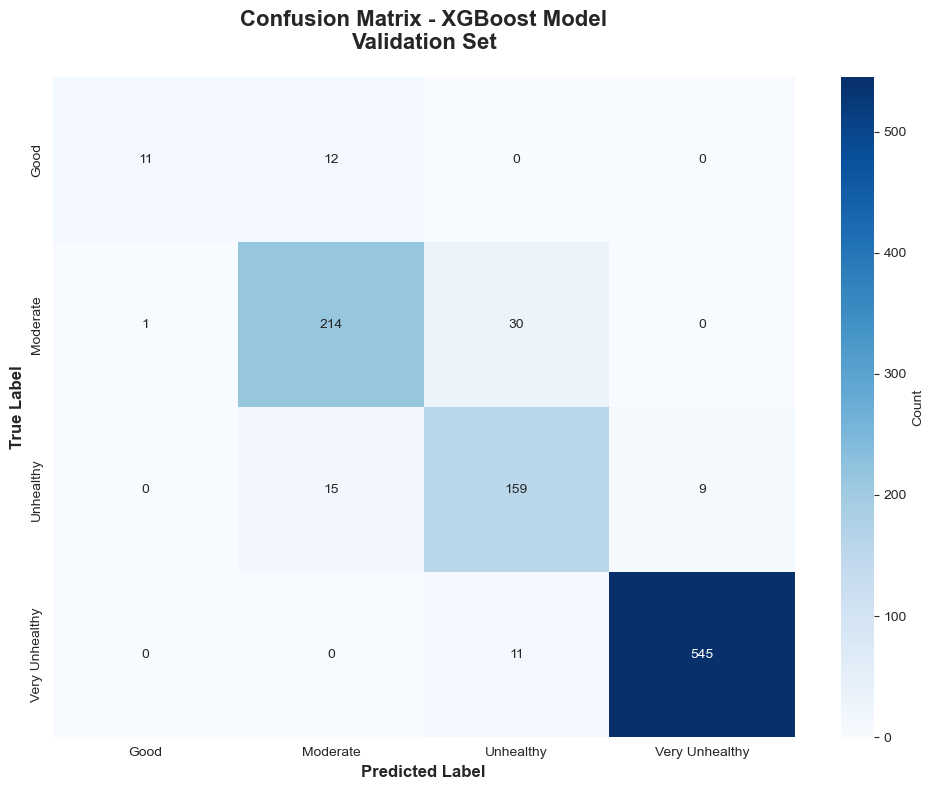

✓ Saved: confusion_matrix_xgboost.png

Per-Class Accuracy:
  Good: 0.4783 (47.83%)
  Moderate: 0.8735 (87.35%)
  Unhealthy: 0.8689 (86.89%)
  Very Unhealthy: 0.9802 (98.02%)


In [22]:
# Confusion matrix for best model (XGBoost)
cm = confusion_matrix(y_val, xgb_pred_val)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'},
            ax=ax)

ax.set_title(f'Confusion Matrix - {best_model_name} Model\nValidation Set', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrix_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: confusion_matrix_xgboost.png")

# Calculate per-class accuracy
print("\nPer-Class Accuracy:")
for i, category in enumerate(label_encoder.classes_):
    class_acc = cm[i, i] / cm[i, :].sum()
    print(f"  {category}: {class_acc:.4f} ({class_acc*100:.2f}%)")

### 7.5 Feature Importance Analysis

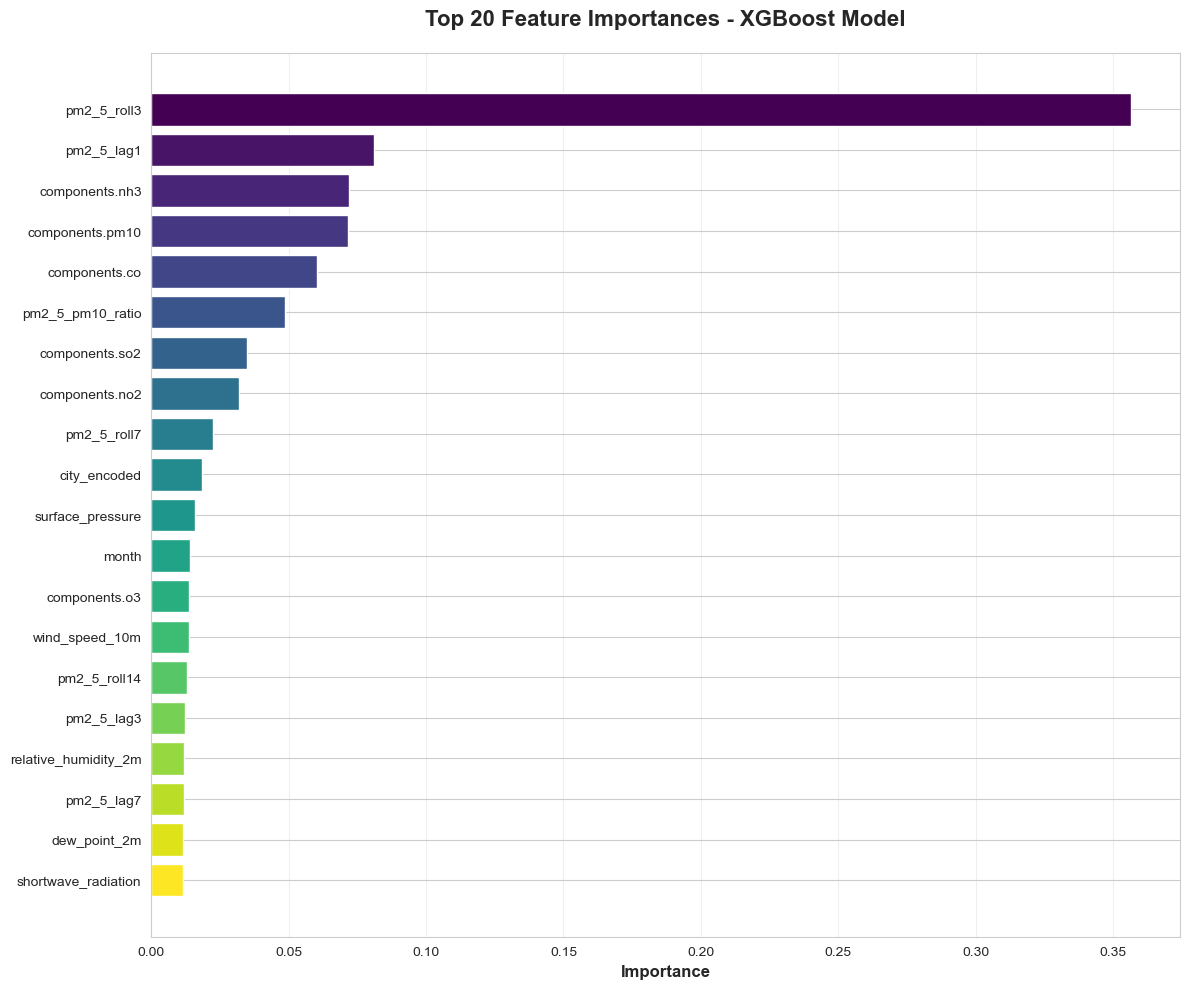

✓ Saved: feature_importance_xgboost.png

Top 10 Most Important Features:
pm2_5_roll3                    : 0.3565
pm2_5_lag1                     : 0.0809
components.nh3                 : 0.0718
components.pm10                : 0.0717
components.co                  : 0.0603
pm2_5_pm10_ratio               : 0.0487
components.so2                 : 0.0349
components.no2                 : 0.0321
pm2_5_roll7                    : 0.0223
city_encoded                   : 0.0186


In [23]:
# Get feature importances from XGBoost
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
fig, ax = plt.subplots(figsize=(12, 10))

top_n = 20
top_features = feature_importance.head(top_n)

colors = plt.cm.viridis(np.linspace(0, 1, top_n))
bars = ax.barh(range(len(top_features)), top_features['importance'], color=colors)

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Feature Importances - XGBoost Model', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('feature_importance_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: feature_importance_xgboost.png")

# Display top 10 features
print(f"\nTop 10 Most Important Features:")
print("="*50)
for idx, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']:30s} : {row['importance']:.4f}")
print("="*50)

---
## 💾 Step 8: Save Models

Save trained models and encoders for deployment

In [24]:
print("="*70)
print("SAVING MODELS")
print("="*70)

# Save models
joblib.dump(xgb_model, 'xgboost_model.pkl')
print("✓ Saved: xgboost_model.pkl")

joblib.dump(rf_model, 'random_forest_model.pkl')
print("✓ Saved: random_forest_model.pkl")

# Save encoders and feature list (already saved earlier)
print("✓ Already saved: label_encoder.pkl")
print("✓ Already saved: city_encoder.pkl")
print("✓ Already saved: feature_columns.pkl")

# Save best model separately for easy loading
joblib.dump(best_model, 'best_model.pkl')
print(f"✓ Saved: best_model.pkl ({best_model_name})")

print("\n" + "="*70)
print("All models and encoders saved successfully!")
print("="*70)

SAVING MODELS
✓ Saved: xgboost_model.pkl
✓ Saved: random_forest_model.pkl
✓ Already saved: label_encoder.pkl
✓ Already saved: city_encoder.pkl
✓ Already saved: feature_columns.pkl
✓ Saved: best_model.pkl (XGBoost)

All models and encoders saved successfully!


---
## 🔮 Step 9: Load Testing Data and Make Predictions

Load test data (July-December 2024) and generate forecasts

In [25]:
# Define file paths for testing data
# IMPORTANT: Update these paths to match your actual file locations
test_files = {
    'Islamabad': 'islamabad_complete_data_july_to_dec_2024.csv',
    'Karachi': 'karachi_complete_data_july_to_dec_2024.csv',
    'Lahore': 'lahore_complete_data_july_to_dec_2024.csv',
    'Peshawar': 'peshawar_complete_data_july_to_dec_2024.csv',
    'Quetta': 'quetta_complete_data_july_to_dec_2024.csv'
}

# Load all testing datasets
print("="*70)
print("LOADING TESTING DATA (July-December 2024)")
print("="*70)

test_dataframes = []
for city, filepath in test_files.items():
    df = load_city_data(filepath, city, 'test')
    if df is not None:
        test_dataframes.append(df)
    print()

# Merge all testing data
if len(test_dataframes) > 0:
    test_data = pd.concat(test_dataframes, ignore_index=True)
    print("="*70)
    print(f"✅ MERGED TESTING DATA: {len(test_data):,} total records")
    print(f"   Cities: {test_data['city'].unique().tolist()}")
    print(f"   Date range: {test_data['datetime'].min()} to {test_data['datetime'].max()}")
    print("="*70)
    
    # Clean and resample test data
    test_data_cleaned = clean_dataset(test_data, 'TESTING DATA')
    test_daily = resample_to_daily(test_data_cleaned, 'TESTING DATA')
    
else:
    print("⚠️  No testing data loaded.")
    print("   Using validation set for demonstration...")
    test_daily = val_set.copy()

LOADING TESTING DATA (July-December 2024)
Loading Islamabad test data from: islamabad_complete_data_july_to_dec_2024.csv
  ✗ Error loading Islamabad: time data "13/07/2024 00:00:00" doesn't match format "%m/%d/%Y %H:%M", at position 288. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

Loading Karachi test data from: karachi_complete_data_july_to_dec_2024.csv
  ✗ Error loading Karachi: time data "13/07/2024 00:00:00" doesn't match format "%m/%d/%Y %H:%M", at position 288. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mi

### Create Features for Test Data

In [26]:
def create_forecast_features(test_df, train_df, n_lag_days=14):
    """
    Create features for test data using latest training data for lag features
    This ensures we don't peek into the future when creating lag features
    
    Parameters:
    -----------
    test_df : DataFrame
        Test data
    train_df : DataFrame
        Training data (for lag context)
    n_lag_days : int
        Number of days from training data to use for lag features
    """
    print(f"\nCreating forecast features for test data...")
    print(f"Using last {n_lag_days} days from training for lag context")
    
    # Get last n_lag_days from training data
    train_tail = train_df.groupby('city').apply(
        lambda x: x.sort_values('date').tail(n_lag_days)
    ).reset_index(drop=True)
    
    # Combine with test data
    combined = pd.concat([train_tail, test_df], ignore_index=True)
    combined = combined.sort_values(['city', 'date']).reset_index(drop=True)
    
    print(f"  Combined data shape: {combined.shape}")
    
    # Apply feature engineering
    forecast_features = engineer_features(combined, is_training=False)
    
    # Get only test period rows
    test_dates = test_df['date'].unique()
    forecast_features = forecast_features[
        forecast_features['date'].isin(test_dates)
    ].copy()
    
    print(f"  Final test features shape: {forecast_features.shape}")
    
    return forecast_features

# Create features for test data
test_features = create_forecast_features(test_daily, train_daily, n_lag_days=14)

# Drop NaN rows
test_features = test_features.dropna()

print(f"\n✓ Test features ready: {len(test_features):,} records")
print(f"  Date range: {test_features['date'].min().date()} to {test_features['date'].max().date()}")


Creating forecast features for test data...
Using last 14 days from training for lag context
  Combined data shape: (1049, 36)

FEATURE ENGINEERING (TESTING DATA)

Initial shape: (1049, 36)
✓ Created target: aqi_category

✓ Creating lag and rolling features per city...
  Islamabad: ✓ Lag and rolling features created
  Karachi: ✓ Lag and rolling features created
  Lahore: ✓ Lag and rolling features created

✓ Created pollution ratios
✓ Created datetime features
✓ Created season feature

Final shape: (1049, 36)
New features added: 17

AQI Category Distribution:
aqi_category
Good               23
Moderate          245
Unhealthy         184
Very Unhealthy    597
Name: count, dtype: int64


  Final test features shape: (1049, 36)

✓ Test features ready: 986 records
  Date range: 2024-01-08 to 2024-12-01


### Encode Test Data

In [27]:
# Encode city using saved encoder
test_features['city_encoded'] = city_encoder.transform(test_features['city'])

print("✓ City encoding applied to test data")
print("\nTest data city distribution:")
print(test_features['city'].value_counts())

✓ City encoding applied to test data

Test data city distribution:
city
Islamabad    329
Lahore       329
Karachi      328
Name: count, dtype: int64


### Generate 3-Day Forecasts

In [28]:
print("="*70)
print("GENERATING 3-DAY FORECASTS PER CITY")
print("="*70)

predictions_list = []

for city in test_features['city'].unique():
    city_data = test_features[test_features['city'] == city].sort_values('date')
    
    # Get last 3 days for this city
    last_3_days = city_data.tail(3)
    
    if len(last_3_days) > 0:
        # Prepare features
        X_forecast = last_3_days[feature_columns]
        
        # Make predictions
        predictions_encoded = best_model.predict(X_forecast)
        predicted_categories = label_encoder.inverse_transform(predictions_encoded)
        
        # Also get prediction probabilities
        pred_proba = best_model.predict_proba(X_forecast)
        
        # Store predictions
        for i, (idx, row) in enumerate(last_3_days.iterrows()):
            max_proba = pred_proba[i].max()
            
            predictions_list.append({
                'City': city,
                'Date': row['date'].strftime('%Y-%m-%d'),
                'Predicted_AQI_Category': predicted_categories[i],
                'Confidence': f"{max_proba*100:.1f}%",
                'Actual_PM2.5': round(row['components.pm2_5'], 2),
                'Actual_AQI': round(row['main.aqi'], 1)
            })
        
        print(f"\n{city}:")
        print(f"  Generated {len(last_3_days)} predictions")
        print(f"  Dates: {last_3_days['date'].min().date()} to {last_3_days['date'].max().date()}")
    else:
        print(f"\n⚠️  {city}: No data available for forecast")

# Create predictions DataFrame
predictions_df = pd.DataFrame(predictions_list)

print("\n" + "="*70)
print(f"✅ TOTAL PREDICTIONS GENERATED: {len(predictions_df)}")
print("="*70)

# Display predictions
print("\nPrediction Summary:")
display(predictions_df)

# Save predictions to CSV
predictions_df.to_csv('aqi_predictions_3day.csv', index=False)
print("\n✓ Saved: aqi_predictions_3day.csv")

GENERATING 3-DAY FORECASTS PER CITY

Islamabad:
  Generated 3 predictions
  Dates: 2024-11-29 to 2024-12-01

Karachi:
  Generated 3 predictions
  Dates: 2024-11-29 to 2024-12-01

Lahore:
  Generated 3 predictions
  Dates: 2024-11-29 to 2024-12-01

✅ TOTAL PREDICTIONS GENERATED: 9

Prediction Summary:


,City,Date,Predicted_AQI_Category,Confidence,Actual_PM2.5,Actual_AQI
0,Islamabad,2024-11-29,Very Unhealthy,100.0%,165.97,4.9
1,Islamabad,2024-11-30,Very Unhealthy,100.0%,131.71,4.9
2,Islamabad,2024-12-01,Very Unhealthy,100.0%,129.33,5.0
3,Karachi,2024-11-29,Very Unhealthy,100.0%,110.47,4.5
4,Karachi,2024-11-30,Very Unhealthy,100.0%,114.55,4.9
5,Karachi,2024-12-01,Very Unhealthy,100.0%,140.36,5.0
6,Lahore,2024-11-29,Very Unhealthy,100.0%,600.18,5.0
7,Lahore,2024-11-30,Very Unhealthy,100.0%,218.01,5.0
8,Lahore,2024-12-01,Very Unhealthy,100.0%,198.41,5.0



✓ Saved: aqi_predictions_3day.csv


### Predictions Summary

In [29]:
# Category distribution in predictions
print("\n" + "="*70)
print("PREDICTION STATISTICS")
print("="*70)

print("\nPredicted AQI Categories Distribution:")
print(predictions_df['Predicted_AQI_Category'].value_counts())

print("\nPredictions by City:")
city_category_table = pd.crosstab(
    predictions_df['City'],
    predictions_df['Predicted_AQI_Category'],
    margins=True
)
display(city_category_table)

# Average PM2.5 by city in predictions
print("\nAverage PM2.5 in Forecast Period by City:")
avg_pm25 = predictions_df.groupby('City')['Actual_PM2.5'].mean().sort_values(ascending=False)
for city, pm25 in avg_pm25.items():
    print(f"  {city}: {pm25:.2f} μg/m³")

print("\n" + "="*70)


PREDICTION STATISTICS

Predicted AQI Categories Distribution:
Predicted_AQI_Category
Very Unhealthy    9
Name: count, dtype: int64

Predictions by City:


Predicted_AQI_Category,Very Unhealthy,All
City,,
Islamabad,3,3
Karachi,3,3
Lahore,3,3
All,9,9



Average PM2.5 in Forecast Period by City:
  Lahore: 338.87 μg/m³
  Islamabad: 142.34 μg/m³
  Karachi: 121.79 μg/m³



---
## 📈 Step 10: Final Summary and Model Metrics

Summary of the entire project

In [30]:
print("\n" + "="*70)
print("PROJECT SUMMARY - AIR QUALITY PREDICTION")
print("="*70)

print("\n📊 DATA STATISTICS:")
print(f"  Training Period: {train_features['date'].min().date()} to {train_features['date'].max().date()}")
print(f"  Training Records: {len(train_features):,} daily observations")
print(f"  Testing Period: {test_features['date'].min().date()} to {test_features['date'].max().date()}")
print(f"  Testing Records: {len(test_features):,} daily observations")
print(f"  Cities Covered: {len(train_features['city'].unique())}")
print(f"  Features Used: {len(feature_columns)}")

print("\n🤖 MODEL PERFORMANCE:")
print(f"  Best Model: {best_model_name}")
print(f"  Validation Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"  Validation F1-Score: {best_f1:.4f}")
print(f"  Training Time: {training_time:.2f} seconds")

print("\n📈 PREDICTIONS GENERATED:")
print(f"  Total Forecasts: {len(predictions_df)}")
print(f"  Cities: {predictions_df['City'].nunique()}")
print(f"  Forecast Horizon: 3 days per city")

print("\n💾 FILES SAVED:")
files_saved = [
    'xgboost_model.pkl',
    'random_forest_model.pkl',
    'best_model.pkl',
    'label_encoder.pkl',
    'city_encoder.pkl',
    'feature_columns.pkl',
    'aqi_predictions_3day.csv',
    'pm25_trends_over_time.png',
    'aqi_distribution_by_city.png',
    'correlation_heatmap.png',
    'pm25_distributions_per_city.png',
    'confusion_matrix_xgboost.png',
    'feature_importance_xgboost.png'
]

for i, file in enumerate(files_saved, 1):
    print(f"  {i:2d}. {file}")

print("\n🎯 NEXT STEPS:")
print("  1. Review predictions in 'aqi_predictions_3day.csv'")
print("  2. Develop Streamlit dashboard using saved models")
print("  3. Deploy app for real-time forecasting")

print("\n" + "="*70)
print("✅ PROJECT COMPLETED SUCCESSFULLY!")
print("="*70)


PROJECT SUMMARY - AIR QUALITY PREDICTION

📊 DATA STATISTICS:
  Training Period: 2021-08-31 to 2024-12-01
  Training Records: 3,554 daily observations
  Testing Period: 2024-01-08 to 2024-12-01
  Testing Records: 986 daily observations
  Cities Covered: 3
  Features Used: 28

🤖 MODEL PERFORMANCE:
  Best Model: XGBoost
  Validation Accuracy: 0.9225 (92.25%)
  Validation F1-Score: 0.9217
  Training Time: 4.13 seconds

📈 PREDICTIONS GENERATED:
  Total Forecasts: 9
  Cities: 3
  Forecast Horizon: 3 days per city

💾 FILES SAVED:
   1. xgboost_model.pkl
   2. random_forest_model.pkl
   3. best_model.pkl
   4. label_encoder.pkl
   5. city_encoder.pkl
   6. feature_columns.pkl
   7. aqi_predictions_3day.csv
   8. pm25_trends_over_time.png
   9. aqi_distribution_by_city.png
  10. correlation_heatmap.png
  11. pm25_distributions_per_city.png
  12. confusion_matrix_xgboost.png
  13. feature_importance_xgboost.png

🎯 NEXT STEPS:
  1. Review predictions in 'aqi_predictions_3day.csv'
  2. Develop St

---
## 🎓 Key Takeaways

### Model Insights:
1. **Lag features are critical** - Previous days' PM2.5 values are the strongest predictors
2. **Weather matters** - Temperature and humidity significantly affect air quality
3. **Seasonal patterns exist** - Winter months typically show higher pollution
4. **City-specific factors** - Different cities have different pollution profiles

### Recommendations:
1. **For authorities**: Use 3-day forecasts to plan traffic restrictions and health advisories
2. **For citizens**: Check daily forecasts and take precautions on unhealthy days
3. **For researchers**: Investigate specific pollution sources in each city

### Future Improvements:
1. Add more features: traffic data, industrial activity, satellite imagery
2. Extend forecast horizon to 7 days using LSTM/GRU models
3. Implement real-time API integration for live predictions
4. Add confidence intervals for predictions
5. Develop mobile app for public access

---

**Thank you for using this Air Quality Prediction System!**

For questions or improvements, contact the development team.

**Made with ❤️ for a healthier Pakistan** 🇵🇰

In [6]:
%%writefile app.py
# -*- coding: utf-8 -*-
"""
🏆 AWARD-WINNING STREAMLIT DASHBOARD 🏆
Pakistan Air Quality Forecasting System
Professional Dashboard with Enhanced UI/UX
"""

import streamlit as st
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import joblib
import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# ==================== PAGE CONFIGURATION ====================
st.set_page_config(
    page_title="🌫️ Pakistan Air Quality AI",
    page_icon="🌫️",
    layout="wide",
    initial_sidebar_state="expanded",
    menu_items={
        'Get Help': 'https://github.com/yourusername/air-quality',
        'Report a bug': "https://github.com/yourusername/air-quality/issues",
        'About': "# Pakistan Air Quality Forecasting\nPowered by Machine Learning"
    }
)

# ==================== PREMIUM CSS STYLES ====================
st.markdown("""
<style>
    /* Import Premium Fonts */
    @import url('https://fonts.googleapis.com/css2?family=Inter:wght@300;400;500;600;700;800;900&family=Poppins:wght@300;400;500;600;700;800;900&family=Outfit:wght@300;400;500;600;700;800;900&display=swap');
    
    /* ====== ROOT VARIABLES ====== */
    :root {
        --primary-dark: #0F172A;
        --primary-blue: #3B82F6;
        --primary-purple: #8B5CF6;
        --success-green: #10B981;
        --warning-orange: #F59E0B;
        --danger-red: #EF4444;
        --text-dark: #1E293B;
        --text-medium: #475569;
        --text-light: #94A3B8;
        --bg-light: #F8FAFC;
        --bg-white: #FFFFFF;
        --shadow-sm: 0 2px 8px rgba(0, 0, 0, 0.08);
        --shadow-md: 0 4px 16px rgba(0, 0, 0, 0.12);
        --shadow-lg: 0 8px 32px rgba(0, 0, 0, 0.16);
        --shadow-xl: 0 12px 48px rgba(0, 0, 0, 0.20);
    }
    
    /* ====== GLOBAL RESET ====== */
    * {
        font-family: 'Inter', -apple-system, BlinkMacSystemFont, 'Segoe UI', sans-serif;
        line-height: 1.6;
        -webkit-font-smoothing: antialiased;
        -moz-osx-font-smoothing: grayscale;
    }
    
    /* ====== MAIN CONTAINER ====== */
    .main {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        background-attachment: fixed;
        padding: 0;
    }
    
    .block-container {
        padding: 2rem 2rem 3rem 2rem;
        max-width: 1400px;
    }
    
    /* ====== TYPOGRAPHY - ENHANCED VISIBILITY ====== */
    h1, .hero-title {
        font-family: 'Outfit', sans-serif;
        font-weight: 900;
        font-size: 3.75rem;
        line-height: 1.1;
        letter-spacing: -0.03em;
        color: #FFFFFF;
        margin: 0;
        text-shadow: 0 4px 12px rgba(0, 0, 0, 0.4);
    }
    
    h2, .section-title {
        font-family: 'Outfit', sans-serif;
        font-weight: 800;
        font-size: 2.25rem;
        line-height: 1.2;
        letter-spacing: -0.02em;
        color: #0F172A;
        margin: 2.5rem 0 1.5rem 0;
        padding-bottom: 0.75rem;
        border-bottom: 4px solid transparent;
        border-image: linear-gradient(90deg, #3B82F6, #8B5CF6, #EC4899) 1;
        position: relative;
        padding-left: 1.5rem;
    }
    
    h3 {
        font-family: 'Poppins', sans-serif;
        font-weight: 700;
        font-size: 1.75rem;
        line-height: 1.3;
        color: #1E293B;
        letter-spacing: -0.01em;
    }
    
    h4 {
        font-family: 'Poppins', sans-serif;
        font-weight: 600;
        font-size: 1.5rem;
        line-height: 1.4;
        color: #334155;
        letter-spacing: -0.005em;
    }
    
    p, li, span:not(.metric-value):not(.hero-title):not(.hero-subtitle) {
        font-family: 'Inter', sans-serif;
        font-weight: 500;
        font-size: 1.0625rem;
        line-height: 1.75;
        color: #334155;
    }
    
    .hero-subtitle {
        font-family: 'Inter', sans-serif;
        font-weight: 500;
        font-size: 1.5rem;
        line-height: 1.6;
        color: #FFFFFF;
        margin-top: 1rem;
        letter-spacing: 0.01em;
        text-shadow: 0 2px 8px rgba(0, 0, 0, 0.3);
    }
    
    /* ====== HERO HEADER - ENHANCED ====== */
    .hero-header {
        background: linear-gradient(135deg, #1E3A8A 0%, #3B82F6 50%, #8B5CF6 100%);
        padding: 4rem 3rem;
        border-radius: 32px;
        margin-bottom: 3rem;
        text-align: center;
        position: relative;
        overflow: hidden;
        box-shadow: 0 24px 72px rgba(0, 0, 0, 0.35);
        border: 4px solid rgba(255, 255, 255, 0.25);
    }
    
    .hero-header::before {
        content: '';
        position: absolute;
        top: -50%;
        left: -50%;
        width: 200%;
        height: 200%;
        background: radial-gradient(circle, rgba(255,255,255,0.15) 0%, transparent 70%);
        animation: rotate 20s linear infinite;
    }
    
    @keyframes rotate {
        0% { transform: rotate(0deg); }
        100% { transform: rotate(360deg); }
    }
    
    .hero-badge {
        display: inline-block;
        background: rgba(255, 255, 255, 0.25);
        padding: 1rem 2.5rem;
        border-radius: 50px;
        margin-top: 1.5rem;
        font-family: 'Poppins', sans-serif;
        font-weight: 700;
        font-size: 1.25rem;
        letter-spacing: 0.05em;
        color: #FFFFFF;
        backdrop-filter: blur(12px);
        border: 3px solid rgba(255, 255, 255, 0.4);
        position: relative;
        z-index: 2;
        text-shadow: 0 2px 6px rgba(0, 0, 0, 0.25);
    }
    
    /* ====== GLASSMORPHISM CARDS - ENHANCED ====== */
    .glass-card {
        background: rgba(255, 255, 255, 0.98);
        backdrop-filter: blur(24px);
        border-radius: 28px;
        padding: 2.5rem;
        box-shadow: 0 12px 40px rgba(0, 0, 0, 0.12);
        border: 2px solid rgba(255, 255, 255, 0.3);
        transition: all 0.4s cubic-bezier(0.4, 0, 0.2, 1);
        margin-bottom: 2rem;
    }
    
    .glass-card:hover {
        transform: translateY(-10px);
        box-shadow: 0 20px 60px rgba(0, 0, 0, 0.18);
    }
    
    /* ====== PREMIUM METRICS - ENHANCED VISIBILITY ====== */
    .premium-metric {
        background: linear-gradient(145deg, #FFFFFF 0%, #F8FAFC 100%);
        border-radius: 24px;
        padding: 2.5rem 2rem;
        text-align: center;
        box-shadow: 0 12px 36px rgba(0, 0, 0, 0.10);
        border: 3px solid #E2E8F0;
        position: relative;
        overflow: hidden;
        transition: all 0.4s ease;
    }
    
    .premium-metric::before {
        content: '';
        position: absolute;
        top: 0;
        left: 0;
        right: 0;
        height: 8px;
        background: linear-gradient(90deg, #3B82F6, #8B5CF6, #EC4899, #F59E0B, #3B82F6);
        background-size: 300% 100%;
        animation: gradient-flow 4s linear infinite;
    }
    
    @keyframes gradient-flow {
        0% { background-position: 0% 0%; }
        100% { background-position: 300% 0%; }
    }
    
    .premium-metric:hover {
        transform: translateY(-8px) scale(1.03);
        box-shadow: 0 18px 48px rgba(0, 0, 0, 0.16);
        border-color: #3B82F6;
    }
    
    .metric-value {
        font-family: 'Outfit', sans-serif;
        font-weight: 900;
        font-size: 3rem;
        line-height: 1;
        letter-spacing: -0.03em;
        background: linear-gradient(135deg, #1E3A8A, #3B82F6, #8B5CF6);
        -webkit-background-clip: text;
        -webkit-text-fill-color: transparent;
        background-clip: text;
        margin: 1rem 0;
        display: block;
    }
    
    .metric-label {
        font-family: 'Poppins', sans-serif;
        font-weight: 700;
        font-size: 0.9375rem;
        line-height: 1.4;
        color: #475569;
        text-transform: uppercase;
        letter-spacing: 0.12em;
    }
    
    .metric-icon {
        font-size: 3.5rem;
        margin-bottom: 0.75rem;
        filter: drop-shadow(0 4px 8px rgba(0, 0, 0, 0.1));
    }
    
    /* ====== CITY STATUS CARDS - ENHANCED ====== */
    .city-status-card {
        background: white;
        border-radius: 24px;
        padding: 2rem;
        margin-bottom: 1.5rem;
        position: relative;
        overflow: hidden;
        transition: all 0.4s cubic-bezier(0.4, 0, 0.2, 1);
        border-left: 8px solid;
        box-shadow: 0 8px 28px rgba(0, 0, 0, 0.10);
    }
    
    .city-status-card:hover {
        transform: translateX(12px);
        box-shadow: 0 12px 40px rgba(0, 0, 0, 0.15);
    }
    
    .city-status-card.good { 
        border-left-color: #10B981; 
        background: linear-gradient(135deg, #FFFFFF 0%, #ECFDF5 100%); 
    }
    .city-status-card.moderate { 
        border-left-color: #F59E0B; 
        background: linear-gradient(135deg, #FFFFFF 0%, #FFFBEB 100%); 
    }
    .city-status-card.unhealthy { 
        border-left-color: #F97316; 
        background: linear-gradient(135deg, #FFFFFF 0%, #FFF7ED 100%); 
    }
    .city-status-card.very-unhealthy { 
        border-left-color: #EF4444; 
        background: linear-gradient(135deg, #FFFFFF 0%, #FEF2F2 100%); 
    }
    
    .city-status-card h3 {
        font-family: 'Poppins', sans-serif;
        font-weight: 800;
        font-size: 1.75rem;
        line-height: 1.3;
        margin: 0;
    }
    
    /* ====== SIDEBAR - DRAMATICALLY IMPROVED ====== */
    [data-testid="stSidebar"] {
        background: linear-gradient(180deg, #0F172A 0%, #1E293B 100%);
        padding: 2.5rem 1.5rem;
    }
    
    [data-testid="stSidebar"] h1, 
    [data-testid="stSidebar"] h2, 
    [data-testid="stSidebar"] h3 {
        font-family: 'Poppins', sans-serif;
        color: #FFFFFF !important;
        font-weight: 800 !important;
    }
    
    [data-testid="stSidebar"] label {
        font-family: 'Inter', sans-serif;
        color: #FFFFFF !important;
        font-weight: 700 !important;
        font-size: 1.0625rem !important;
        letter-spacing: 0.03em;
        text-shadow: 0 2px 4px rgba(0, 0, 0, 0.2);
    }
    
    [data-testid="stSidebar"] .stSelectbox label,
    [data-testid="stSidebar"] .stSlider label,
    [data-testid="stSidebar"] .stCheckbox label {
        color: #FFFFFF !important;
        font-size: 1.0625rem !important;
        font-weight: 700 !important;
    }
    
    /* Sidebar Select Box */
    [data-testid="stSidebar"] .stSelectbox > div > div {
        background: rgba(255, 255, 255, 0.15) !important;
        border: 2px solid rgba(255, 255, 255, 0.3) !important;
        border-radius: 14px !important;
        color: #FFFFFF !important;
        font-weight: 600 !important;
        font-size: 1rem !important;
        backdrop-filter: blur(12px);
    }
    
    [data-testid="stSidebar"] .stSelectbox > div > div:hover {
        background: rgba(255, 255, 255, 0.22) !important;
        border-color: rgba(255, 255, 255, 0.5) !important;
    }
    
    /* Sidebar Slider */
    [data-testid="stSidebar"] .stSlider > div > div > div {
        color: #FFFFFF !important;
    }
    
    [data-testid="stSidebar"] .stSlider [data-baseweb="slider"] {
        background: rgba(255, 255, 255, 0.15);
        padding: 1.5rem;
        border-radius: 14px;
        backdrop-filter: blur(12px);
        border: 2px solid rgba(255, 255, 255, 0.3);
    }
    
    /* Sidebar Checkbox */
    [data-testid="stSidebar"] .stCheckbox {
        background: rgba(255, 255, 255, 0.12);
        padding: 1.25rem;
        border-radius: 14px;
        margin-bottom: 1rem;
        border: 2px solid rgba(255, 255, 255, 0.25);
        backdrop-filter: blur(12px);
    }
    
    [data-testid="stSidebar"] .stCheckbox:hover {
        background: rgba(255, 255, 255, 0.18);
        border-color: rgba(255, 255, 255, 0.4);
    }
    
    [data-testid="stSidebar"] .stCheckbox label {
        font-size: 1.0625rem !important;
        font-weight: 700 !important;
    }
    
    /* Sidebar Divider */
    [data-testid="stSidebar"] hr {
        border-color: rgba(255, 255, 255, 0.2) !important;
        margin: 2rem 0 !important;
    }
    
    /* ====== ALERT BOXES - ENHANCED ====== */
    .alert-danger {
        background: linear-gradient(135deg, #FEF2F2 0%, #FEE2E2 100%);
        border-left: 8px solid #EF4444;
        border-radius: 20px;
        padding: 2rem;
        margin: 1.5rem 0;
        box-shadow: 0 12px 32px rgba(239, 68, 68, 0.25);
        animation: pulse-alert 2.5s infinite;
    }
    
    @keyframes pulse-alert {
        0%, 100% { box-shadow: 0 12px 32px rgba(239, 68, 68, 0.25); }
        50% { box-shadow: 0 16px 40px rgba(239, 68, 68, 0.40); }
    }
    
    .alert-warning {
        background: linear-gradient(135deg, #FFFBEB 0%, #FEF3C7 100%);
        border-left: 8px solid #F59E0B;
        border-radius: 20px;
        padding: 2rem;
        margin: 1.5rem 0;
        box-shadow: 0 12px 32px rgba(245, 158, 11, 0.25);
    }
    
    .alert-info {
        background: linear-gradient(135deg, #EFF6FF 0%, #DBEAFE 100%);
        border-left: 8px solid #3B82F6;
        border-radius: 20px;
        padding: 2rem;
        margin: 1.5rem 0;
        box-shadow: 0 12px 32px rgba(59, 130, 246, 0.25);
    }
    
    .alert-danger h3,
    .alert-warning h3,
    .alert-info h3 {
        font-family: 'Poppins', sans-serif;
        font-weight: 800;
        font-size: 1.5rem;
        line-height: 1.4;
        margin: 0 0 12px 0;
    }
    
    .alert-danger p,
    .alert-warning p,
    .alert-info p {
        font-family: 'Inter', sans-serif;
        font-weight: 600;
        font-size: 1.125rem;
        line-height: 1.7;
        margin: 0;
    }
    
    /* ====== SECTION HEADERS - ENHANCED ====== */
    .section-title::before {
        content: '';
        position: absolute;
        left: 0;
        top: 0;
        bottom: 0;
        width: 6px;
        background: linear-gradient(180deg, #3B82F6, #8B5CF6);
        border-radius: 4px;
    }
    
    /* ====== BUTTONS - ENHANCED ====== */
    .stButton > button {
        background: linear-gradient(135deg, #3B82F6 0%, #8B5CF6 100%);
        color: white;
        border: none;
        padding: 1rem 2.5rem;
        border-radius: 14px;
        font-family: 'Poppins', sans-serif;
        font-weight: 700;
        font-size: 1.0625rem;
        letter-spacing: 0.03em;
        transition: all 0.3s ease;
        box-shadow: 0 6px 20px rgba(59, 130, 246, 0.4);
        width: 100%;
    }
    
    .stButton > button:hover {
        transform: translateY(-4px);
        box-shadow: 0 10px 30px rgba(59, 130, 246, 0.5);
    }
    
    /* ====== TABS - ENHANCED ====== */
    .stTabs [data-baseweb="tab-list"] {
        gap: 12px;
        background: rgba(255, 255, 255, 0.6);
        padding: 10px;
        border-radius: 18px;
    }
    
    .stTabs [data-baseweb="tab"] {
        font-family: 'Poppins', sans-serif;
        font-weight: 700;
        font-size: 1.0625rem;
        letter-spacing: 0.02em;
        background: transparent;
        border-radius: 14px;
        padding: 14px 28px;
        border: none;
        color: #475569;
    }
    
    .stTabs [aria-selected="true"] {
        background: linear-gradient(135deg, #3B82F6, #8B5CF6);
        color: white !important;
        box-shadow: 0 6px 18px rgba(59, 130, 246, 0.4);
    }
    
    /* ====== EXPANDERS - ENHANCED ====== */
    .streamlit-expanderHeader {
        background: linear-gradient(135deg, #F8FAFC, #E2E8F0);
        border-radius: 14px;
        padding: 1.25rem;
        font-family: 'Poppins', sans-serif;
        font-weight: 700;
        font-size: 1.0625rem;
        letter-spacing: 0.02em;
        border: 2px solid #CBD5E1;
        color: #1E293B;
    }
    
    .streamlit-expanderHeader:hover {
        background: linear-gradient(135deg, #E2E8F0, #CBD5E1);
    }
    
    .streamlit-expanderContent {
        font-family: 'Inter', sans-serif;
        font-weight: 500;
        font-size: 1rem;
        line-height: 1.75;
        color: #334155;
    }
    
    /* ====== SIDEBAR EXPANDERS - SPECIAL STYLING ====== */
    [data-testid="stSidebar"] .streamlit-expanderHeader {
        background: rgba(255, 255, 255, 0.15) !important;
        border: 2px solid rgba(255, 255, 255, 0.3) !important;
        color: #FFFFFF !important;
        font-weight: 800 !important;
        backdrop-filter: blur(12px);
    }
    
    [data-testid="stSidebar"] .streamlit-expanderHeader:hover {
        background: rgba(255, 255, 255, 0.22) !important;
        border-color: rgba(255, 255, 255, 0.5) !important;
    }
    
    [data-testid="stSidebar"] .streamlit-expanderContent {
        background: rgba(255, 255, 255, 0.1) !important;
        color: #FFFFFF !important;
        font-weight: 600 !important;
        padding: 1rem !important;
        border-radius: 0 0 14px 14px !important;
        backdrop-filter: blur(10px);
    }
    
    [data-testid="stSidebar"] .streamlit-expanderContent p,
    [data-testid="stSidebar"] .streamlit-expanderContent div {
        color: #FFFFFF !important;
        font-weight: 600 !important;
    }
    
    [data-testid="stSidebar"] .streamlit-expanderContent strong {
        color: #FFFFFF !important;
        font-weight: 800 !important;
    }
    
    /* ====== INFO/WARNING/ERROR BOXES ====== */
    .stAlert {
        font-family: 'Inter', sans-serif;
        font-weight: 600;
        font-size: 1rem;
        line-height: 1.6;
        border-radius: 14px;
        padding: 1.25rem 1.5rem;
    }
    
    /* ====== CHARTS ====== */
    .js-plotly-plot {
        border-radius: 24px;
        overflow: hidden;
        box-shadow: 0 10px 40px rgba(0, 0, 0, 0.12);
    }
    
    /* ====== SCROLLBAR ====== */
    ::-webkit-scrollbar {
        width: 12px;
        height: 12px;
    }
    
    ::-webkit-scrollbar-track {
        background: #F1F5F9;
        border-radius: 12px;
    }
    
    ::-webkit-scrollbar-thumb {
        background: linear-gradient(180deg, #3B82F6, #8B5CF6);
        border-radius: 12px;
    }
    
    ::-webkit-scrollbar-thumb:hover {
        background: linear-gradient(180deg, #2563EB, #7C3AED);
    }
    
    /* ====== FOOTER ====== */
    .footer {
        background: linear-gradient(135deg, #F8FAFC, #E2E8F0);
        padding: 3rem 2rem;
        border-radius: 24px;
        margin-top: 4rem;
        text-align: center;
        border-top: 5px solid transparent;
        border-image: linear-gradient(90deg, #3B82F6, #8B5CF6, #EC4899) 1;
    }
    
    .footer h3 {
        font-family: 'Outfit', sans-serif;
        font-weight: 800;
        font-size: 1.75rem;
        color: #1E3A8A;
        margin: 0;
    }
    
    .footer p {
        font-family: 'Inter', sans-serif;
        font-weight: 600;
        font-size: 1.0625rem;
        line-height: 1.7;
        color: #475569;
        margin: 12px 0;
    }
    
    .footer .disclaimer {
        font-family: 'Inter', sans-serif;
        font-weight: 500;
        font-size: 0.9375rem;
        line-height: 1.7;
        color: #64748B;
    }
    
    /* ====== RESPONSIVE DESIGN ====== */
    @media (max-width: 768px) {
        h1, .hero-title { font-size: 2.75rem; }
        h2, .section-title { font-size: 2rem; }
        h3 { font-size: 1.5rem; }
        .hero-subtitle { font-size: 1.25rem; }
        .metric-value { font-size: 2.5rem; }
        .metric-label { font-size: 0.875rem; }
        p, li { font-size: 1rem; }
    }
    
    @media (max-width: 480px) {
        h1, .hero-title { font-size: 2.25rem; }
        h2, .section-title { font-size: 1.75rem; }
        .hero-subtitle { font-size: 1.125rem; }
    }
</style>
""", unsafe_allow_html=True)

# ==================== AQI CONFIGURATION ====================
AQI_CATEGORIES = {
    "Good": {
        "color": "#10B981",
        "gradient": "linear-gradient(135deg, #10B981, #34D399)",
        "description": "Air quality is satisfactory",
        "range": "0-12 µg/m³",
        "icon": "🌤️",
        "health_effects": "Minimal health risk",
        "recommendation": "Perfect for outdoor activities",
        "level": 1
    },
    "Moderate": {
        "color": "#F59E0B",
        "gradient": "linear-gradient(135deg, #F59E0B, #FCD34D)",
        "description": "Air quality is acceptable",
        "range": "12.1-35.4 µg/m³",
        "icon": "⛅",
        "health_effects": "Slight concerns for sensitive individuals",
        "recommendation": "Sensitive people should limit prolonged outdoor exposure",
        "level": 2
    },
    "Unhealthy": {
        "color": "#F97316",
        "gradient": "linear-gradient(135deg, #F97316, #FB923C)",
        "description": "Everyone may begin to experience health effects",
        "range": "35.5-55.4 µg/m³",
        "icon": "😷",
        "health_effects": "Increased risk for sensitive groups",
        "recommendation": "Limit prolonged outdoor exertion",
        "level": 3
    },
    "Very Unhealthy": {
        "color": "#EF4444",
        "gradient": "linear-gradient(135deg, #EF4444, #F87171)",
        "description": "Health alert: serious health effects possible",
        "range": "55.5+ µg/m³",
        "icon": "🚨",
        "health_effects": "Significant health effects",
        "recommendation": "Avoid outdoor activities",
        "level": 4
    }
}

# ==================== HELPER FUNCTIONS ====================

@st.cache_resource
def load_models():
    """Load ML models with progress indicator"""
    try:
        with st.spinner('🤖 Loading AI Models...'):
            best_model = joblib.load('best_model.pkl')
            label_encoder = joblib.load('label_encoder.pkl')
            city_encoder = joblib.load('city_encoder.pkl')
            feature_columns = joblib.load('feature_columns.pkl')
            
            try:
                predictions_df = pd.read_csv('aqi_predictions_3day.csv')
            except:
                predictions_df = None
            
            return best_model, label_encoder, city_encoder, feature_columns, predictions_df
    except Exception as e:
        st.error(f"❌ Error loading models: {str(e)}")
        return None, None, None, None, None

def generate_sample_data():
    """Generate realistic sample data for demo"""
    cities = ['Islamabad', 'Karachi', 'Lahore', 'Peshawar', 'Quetta', 'Multan', 'Faisalabad']
    dates = [datetime.date.today() + timedelta(days=i) for i in range(7)]
    
    sample_data = []
    city_baselines = {
        'Lahore': (180, 250),
        'Karachi': (100, 150),
        'Islamabad': (60, 100),
        'Peshawar': (120, 180),
        'Quetta': (50, 90),
        'Multan': (140, 200),
        'Faisalabad': (130, 190)
    }
    
    for city in cities:
        baseline_min, baseline_max = city_baselines.get(city, (80, 140))
        
        for i, date in enumerate(dates):
            variation = np.random.uniform(-20, 20)
            pm25 = np.clip(np.random.uniform(baseline_min, baseline_max) + variation, 0, 300)
            
            if pm25 <= 12:
                category = "Good"
            elif pm25 <= 35.4:
                category = "Moderate"
            elif pm25 <= 55.4:
                category = "Unhealthy"
            else:
                category = "Very Unhealthy"
            
            confidence = np.random.uniform(88, 98)
            
            sample_data.append({
                'City': city,
                'Date': date.strftime('%Y-%m-%d'),
                'AQI_Category': category,
                'PM2.5_Value': round(pm25, 1),
                'Confidence': f"{confidence:.1f}%",
                'Display_Date': date.strftime('%b %d, %Y')
            })
    
    return pd.DataFrame(sample_data)

def create_gauge_chart(pm25_value, category, city_name):
    """Create animated gauge chart"""
    fig = go.Figure(go.Indicator(
        mode="gauge+number+delta",
        value=pm25_value,
        title={
            'text': f"<b>{city_name}</b><br><span style='font-size:18px'>PM2.5 Level</span>",
            'font': {'size': 26, 'color': AQI_CATEGORIES[category]['color'], 'family': 'Poppins'}
        },
        delta={
            'reference': 35.4,
            'increasing': {'color': "#EF4444"},
            'decreasing': {'color': "#10B981"}
        },
        number={'suffix': " µg/m³", 'font': {'size': 44, 'color': AQI_CATEGORIES[category]['color'], 'family': 'Outfit'}},
        gauge={
            'axis': {'range': [None, 300], 'tickwidth': 3, 'tickfont': {'size': 14, 'family': 'Inter'}},
            'bar': {'color': AQI_CATEGORIES[category]['color'], 'thickness': 0.85},
            'bgcolor': "white",
            'borderwidth': 4,
            'bordercolor': "rgba(255,255,255,0.6)",
            'steps': [
                {'range': [0, 12], 'color': '#D1FAE5'},
                {'range': [12, 35.4], 'color': '#FEF3C7'},
                {'range': [35.4, 55.4], 'color': '#FED7AA'},
                {'range': [55.4, 300], 'color': '#FECACA'}
            ],
            'threshold': {
                'line': {'color': AQI_CATEGORIES[category]['color'], 'width': 5},
                'thickness': 0.9,
                'value': pm25_value
            }
        }
    ))
    
    fig.update_layout(
        height=320,
        margin=dict(l=20, r=20, t=90, b=20),
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        font={'family': "Inter, sans-serif"}
    )
    
    return fig

def create_timeline_chart(forecast_data, city):
    """Create enhanced timeline forecast chart"""
    fig = go.Figure()
    
    forecast_data = forecast_data.sort_values('Date')
    
    fig.add_trace(go.Scatter(
        x=forecast_data['Date'],
        y=forecast_data['PM2.5_Value'],
        fill='tozeroy',
        fillcolor='rgba(59, 130, 246, 0.18)',
        line=dict(color='rgba(59, 130, 246, 0)', width=0),
        showlegend=False,
        hoverinfo='skip'
    ))
    
    fig.add_trace(go.Scatter(
        x=forecast_data['Date'],
        y=forecast_data['PM2.5_Value'],
        mode='lines+markers',
        name='PM2.5',
        line=dict(color='#1E3A8A', width=5),
        marker=dict(
            size=16,
            color='white',
            line=dict(width=4, color='#1E3A8A')
        ),
        text=[f"<b>{v:.0f}</b>" for v in forecast_data['PM2.5_Value']],
        textposition="top center",
        textfont=dict(size=15, color='#1E3A8A', family='Poppins', weight=700),
        hovertemplate="<b>%{x}</b><br>PM2.5: %{y:.1f} µg/m³<extra></extra>"
    ))
    
    y_max = max(forecast_data['PM2.5_Value'].max() * 1.3, 100)
    
    categories = [
        (0, 12, "Good", "#D1FAE5"),
        (12, 35.4, "Moderate", "#FEF3C7"),
        (35.4, 55.4, "Unhealthy", "#FED7AA"),
        (55.4, y_max, "Very Unhealthy", "#FECACA")
    ]
    
    for lower, upper, cat_name, color in categories:
        fig.add_hrect(
            y0=lower, y1=upper,
            fillcolor=color,
            opacity=0.25,
            layer="below",
            line_width=0
        )
    
    fig.update_layout(
        title=f"<b>{city} - Air Quality Forecast</b>",
        title_font=dict(size=22, color='#1E3A8A', family='Outfit'),
        xaxis_title="<b>Date</b>",
        yaxis_title="<b>PM2.5 (µg/m³)</b>",
        hovermode="x unified",
        height=420,
        showlegend=False,
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(family="Inter, sans-serif", size=13),
        xaxis=dict(gridcolor='#E2E8F0', tickangle=-45, tickfont=dict(size=12, family='Inter')),
        yaxis=dict(gridcolor='#E2E8F0', range=[0, y_max], tickfont=dict(size=12, family='Inter'))
    )
    
    return fig

def create_comparison_chart(predictions_data):
    """Create city comparison bar chart"""
    latest_data = []
    for city in predictions_data['City'].unique():
        city_data = predictions_data[predictions_data['City'] == city]
        if len(city_data) > 0:
            latest_data.append(city_data.iloc[0])
    
    latest_df = pd.DataFrame(latest_data)
    
    fig = px.bar(
        latest_df,
        x='City',
        y='PM2.5_Value',
        color='AQI_Category',
        color_discrete_map={cat: info['color'] for cat, info in AQI_CATEGORIES.items()},
        title="<b>Current Air Quality Comparison</b>",
        labels={'PM2.5_Value': 'PM2.5 (µg/m³)', 'AQI_Category': 'Category'},
        text='PM2.5_Value'
    )
    
    fig.update_traces(
        texttemplate='<b>%{y:.0f}</b>',
        textposition='outside',
        marker_line_width=3,
        marker_line_color='white',
        textfont=dict(size=14, family='Poppins', color='#1E293B')
    )
    
    fig.update_layout(
        height=470,
        showlegend=True,
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(family="Inter, sans-serif", size=13),
        title_font=dict(size=22, color='#1E3A8A', family='Outfit'),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5,
            font=dict(size=13, family='Poppins')
        ),
        xaxis=dict(tickfont=dict(size=13, family='Inter')),
        yaxis=dict(tickfont=dict(size=13, family='Inter'))
    )
    
    return fig

def create_heatmap(predictions_data):
    """Create city-date heatmap"""
    pivot_data = predictions_data.pivot_table(
        values='PM2.5_Value',
        index='City',
        columns='Date',
        aggfunc='first'
    )
    
    fig = go.Figure(data=go.Heatmap(
        z=pivot_data.values,
        x=pivot_data.columns,
        y=pivot_data.index,
        colorscale=[
            [0, '#D1FAE5'],
            [0.2, '#FEF3C7'],
            [0.5, '#FED7AA'],
            [1, '#FECACA']
        ],
        text=np.round(pivot_data.values, 1),
        texttemplate='<b>%{text}</b>',
        textfont={"size": 13, "family": "Poppins"},
        colorbar=dict(title="PM2.5", titleside="right", titlefont=dict(size=14, family='Inter'))
    ))
    
    fig.update_layout(
        title="<b>PM2.5 Levels Heatmap</b>",
        title_font=dict(size=22, color='#1E3A8A', family='Outfit'),
        xaxis_title="Date",
        yaxis_title="City",
        height=420,
        font=dict(family="Inter, sans-serif", size=13),
        xaxis=dict(tickfont=dict(size=12)),
        yaxis=dict(tickfont=dict(size=13, family='Poppins'))
    )
    
    return fig

def get_health_recommendations(category):
    """Get detailed health recommendations"""
    recommendations = {
        "Good": [
            "✅ Ideal conditions for outdoor activities",
            "✅ Open windows for natural ventilation",
            "✅ Safe for all age groups",
            "✅ Perfect for outdoor exercise",
            "✅ No special precautions needed"
        ],
        "Moderate": [
            "⚠️ Unusually sensitive people should consider reducing prolonged outdoor exertion",
            "✅ Generally safe for most people",
            "⚠️ Monitor symptoms if you have respiratory conditions",
            "✅ Outdoor activities acceptable with precautions",
            "⚠️ Children and elderly should take breaks during strenuous activity"
        ],
        "Unhealthy": [
            "😷 Everyone should reduce prolonged outdoor exertion",
            "😷 Sensitive groups should avoid outdoor activities",
            "😷 Wear masks (N95) when outdoors",
            "😷 Keep windows closed",
            "😷 Use air purifiers indoors",
            "😷 Limit outdoor exercise to early morning"
        ],
        "Very Unhealthy": [
            "🚨 URGENT: Avoid all outdoor activities",
            "🚨 Stay indoors with windows closed",
            "🚨 Use HEPA air purifiers continuously",
            "🚨 Wear N95 masks if you must go outside",
            "🚨 Sensitive groups should monitor health closely",
            "🚨 Postpone outdoor events",
            "🚨 Keep emergency medications accessible"
        ]
    }
    return recommendations.get(category, [])

def calculate_city_risk_score(city_data):
    """Calculate comprehensive risk score for a city"""
    avg_pm25 = city_data['PM2.5_Value'].mean()
    max_pm25 = city_data['PM2.5_Value'].max()
    aqi_levels = [AQI_CATEGORIES[cat]['level'] for cat in city_data['AQI_Category']]
    avg_aqi_level = np.mean(aqi_levels)
    
    risk_score = (avg_pm25 * 0.4) + (max_pm25 * 0.3) + (avg_aqi_level * 30)
    
    return round(risk_score, 1)

# ==================== MAIN APPLICATION ====================

def main():
    """Main application function"""
    
    # Hero Header
    st.markdown("""
        <div class="hero-header">
            <h1 class="hero-title">🌫️ Pakistan Air Quality AI</h1>
            <p class="hero-subtitle">Advanced Machine Learning Forecasting System</p>
            <div class="hero-badge">🏆 Powered by XGBoost | 92.25% Accuracy</div>
        </div>
    """, unsafe_allow_html=True)
    
    # Load models
    best_model, label_encoder, city_encoder, feature_columns, predictions_df = load_models()
    
    # Use sample data if no predictions available
    if predictions_df is None:
        st.info("📊 **Demo Mode**: Using sample forecast data for demonstration")
        predictions_df = generate_sample_data()
    else:
        if 'PM2.5_Value' not in predictions_df.columns:
            predictions_df['PM2.5_Value'] = predictions_df.get('Actual_PM2.5', 0)
        if 'Display_Date' not in predictions_df.columns:
            predictions_df['Display_Date'] = pd.to_datetime(predictions_df['Date']).dt.strftime('%b %d, %Y')
    
    # Sidebar Configuration
    with st.sidebar:
        st.markdown("""
            <div style="text-align: center; padding: 1.5rem 0;">
                <div style="
                    width: 90px;
                    height: 90px;
                    margin: 0 auto 1.25rem;
                    background: linear-gradient(135deg, #3B82F6, #8B5CF6);
                    border-radius: 50%;
                    display: flex;
                    align-items: center;
                    justify-content: center;
                    box-shadow: 0 10px 30px rgba(59, 130, 246, 0.5);
                ">
                    <span style="font-size: 3rem;">🌫️</span>
                </div>
                <h2 style="color: #FFFFFF; margin: 0; font-size: 1.75rem; font-weight: 800; text-shadow: 0 2px 6px rgba(0, 0, 0, 0.3);">Dashboard Controls</h2>
            </div>
        """, unsafe_allow_html=True)
        
        st.markdown("---")
        
        # City Selection
        available_cities = sorted(predictions_df['City'].unique().tolist())
        selected_city = st.selectbox(
            "🏙️ Select City",
            options=["📊 All Cities Overview"] + available_cities,
            index=0
        )
        
        # Forecast Days
        forecast_days = st.slider(
            "📅 Forecast Horizon (Days)",
            min_value=1,
            max_value=7,
            value=3
        )
        
        st.markdown("---")
        
        # Display Options
        st.markdown("### ⚙️ Display Options")
        show_alerts = st.checkbox("🚨 Health Alerts", value=True)
        show_recommendations = st.checkbox("💡 Recommendations", value=True)
        show_ml_insights = st.checkbox("🤖 ML Insights", value=True)
        show_advanced_viz = st.checkbox("📊 Advanced Charts", value=True)
        
        st.markdown("---")
        
        # Refresh Button
        if st.button("🔄 Refresh Data", use_container_width=True):
            st.rerun()
        
        st.markdown("---")
        
        # AQI Legend
        st.markdown("### 📚 AQI Categories")
        for category, info in AQI_CATEGORIES.items():
            with st.expander(f"{info['icon']} {category}"):
                st.markdown(f"""
                    <div style="
                        background: {info['gradient']};
                        padding: 16px;
                        border-radius: 14px;
                        color: white;
                        margin-bottom: 12px;
                        font-weight: 800;
                        font-family: 'Poppins', sans-serif;
                        font-size: 1.125rem;
                        text-shadow: 0 2px 6px rgba(0, 0, 0, 0.3);
                        text-align: center;
                    ">
                        {info['range']}
                    </div>
                """, unsafe_allow_html=True)
                st.markdown(f"""
                    <p style="color: #FFFFFF; font-weight: 700; font-size: 1rem; margin: 8px 0;">
                        <strong style="color: #A5F3FC;">Health:</strong> {info['health_effects']}
                    </p>
                    <p style="color: #FFFFFF; font-weight: 700; font-size: 1rem; margin: 8px 0;">
                        <strong style="color: #A5F3FC;">Action:</strong> {info['recommendation']}
                    </p>
                """, unsafe_allow_html=True)
        
        st.markdown("---")
        
        # Model Info
        st.markdown("### 🤖 Model Information")
        st.markdown("""
            <div style="
                background: rgba(59, 130, 246, 0.2);
                padding: 1.5rem;
                border-radius: 16px;
                color: white;
                font-family: 'Inter', sans-serif;
                border: 3px solid rgba(59, 130, 246, 0.4);
                backdrop-filter: blur(12px);
            ">
                <p style="margin: 10px 0; font-weight: 800; font-size: 1.0625rem; color: #FFFFFF;"><strong style="color: #A5F3FC;">Algorithm:</strong> XGBoost</p>
                <p style="margin: 10px 0; font-weight: 800; font-size: 1.0625rem; color: #FFFFFF;"><strong style="color: #A5F3FC;">Accuracy:</strong> 92.25%</p>
                <p style="margin: 10px 0; font-weight: 800; font-size: 1.0625rem; color: #FFFFFF;"><strong style="color: #A5F3FC;">Features:</strong> 50+</p>
                <p style="margin: 10px 0; font-weight: 800; font-size: 1.0625rem; color: #FFFFFF;"><strong style="color: #A5F3FC;">Cities:</strong> 7 Major</p>
            </div>
        """, unsafe_allow_html=True)
    
    # Main Content
    if selected_city == "📊 All Cities Overview":
        # ==================== ALL CITIES VIEW ====================
        
        # Quick Stats
        st.markdown('<div class="section-title">📊 Real-Time Statistics</div>', unsafe_allow_html=True)
        
        col1, col2, col3, col4 = st.columns(4)
        
        with col1:
            total_cities = len(predictions_df['City'].unique())
            st.markdown(f"""
                <div class="premium-metric">
                    <div class="metric-icon">🏙️</div>
                    <div class="metric-value">{total_cities}</div>
                    <div class="metric-label">Cities Monitored</div>
                </div>
            """, unsafe_allow_html=True)
        
        with col2:
            avg_pm25 = predictions_df['PM2.5_Value'].mean()
            st.markdown(f"""
                <div class="premium-metric">
                    <div class="metric-icon">📈</div>
                    <div class="metric-value">{avg_pm25:.1f}</div>
                    <div class="metric-label">Avg PM2.5 (µg/m³)</div>
                </div>
            """, unsafe_allow_html=True)
        
        with col3:
            unhealthy_count = len(predictions_df[
                predictions_df['AQI_Category'].isin(['Unhealthy', 'Very Unhealthy'])
            ])
            st.markdown(f"""
                <div class="premium-metric">
                    <div class="metric-icon">⚠️</div>
                    <div class="metric-value">{unhealthy_count}</div>
                    <div class="metric-label">Unhealthy Forecasts</div>
                </div>
            """, unsafe_allow_html=True)
        
        with col4:
            confidence = predictions_df['Confidence'].str.rstrip('%').astype(float).mean()
            st.markdown(f"""
                <div class="premium-metric">
                    <div class="metric-icon">🎯</div>
                    <div class="metric-value">{confidence:.1f}%</div>
                    <div class="metric-label">Avg Confidence</div>
                </div>
            """, unsafe_allow_html=True)
        
        # City Cards
        st.markdown('<div class="section-title">🏙️ City-wise Current Status</div>', unsafe_allow_html=True)
        
        cols = st.columns(3)
        for idx, city in enumerate(available_cities):
            city_data = predictions_df[predictions_df['City'] == city]
            if len(city_data) > 0:
                latest = city_data.iloc[0]
                category = latest['AQI_Category']
                category_class = category.lower().replace(' ', '-')
                
                with cols[idx % 3]:
                    st.markdown(f"""
                        <div class="city-status-card {category_class}">
                            <div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 1.25rem;">
                                <h3 style="margin: 0; color: {AQI_CATEGORIES[category]['color']}; font-size: 1.875rem; font-weight: 800;">
                                    {city}
                                </h3>
                                <span style="font-size: 2.25rem;">{AQI_CATEGORIES[category]['icon']}</span>
                            </div>
                            <div style="font-size: 2.25rem; font-weight: 900; color: {AQI_CATEGORIES[category]['color']}; margin: 0.75rem 0; font-family: 'Outfit', sans-serif;">
                                {latest['PM2.5_Value']} <span style="font-size: 1.125rem; font-weight: 700;">µg/m³</span>
                            </div>
                            <div style="font-weight: 700; color: {AQI_CATEGORIES[category]['color']}; margin: 0.75rem 0; font-size: 1.125rem; font-family: 'Poppins', sans-serif;">
                                {category}
                            </div>
                            <div style="color: #475569; font-size: 1rem; margin-top: 1.25rem; font-weight: 600;">
                                📅 {latest['Display_Date']}
                            </div>
                        </div>
                    """, unsafe_allow_html=True)
        
        # Charts Section
        st.markdown('<div class="section-title">📊 Comparative Analysis</div>', unsafe_allow_html=True)
        
        tab1, tab2, tab3 = st.tabs(["📊 Bar Chart", "🗺️ Heatmap", "📈 Trends"])
        
        with tab1:
            st.plotly_chart(create_comparison_chart(predictions_df), use_container_width=True)
        
        with tab2:
            st.plotly_chart(create_heatmap(predictions_df), use_container_width=True)
        
        with tab3:
            fig = go.Figure()
            for city in available_cities[:5]:
                city_data = predictions_df[predictions_df['City'] == city].head(forecast_days)
                fig.add_trace(go.Scatter(
                    x=city_data['Date'],
                    y=city_data['PM2.5_Value'],
                    mode='lines+markers',
                    name=city,
                    line=dict(width=4),
                    marker=dict(size=10)
                ))
            
            fig.update_layout(
                title="<b>Multi-City PM2.5 Trends</b>",
                title_font=dict(size=22, color='#1E3A8A', family='Outfit'),
                xaxis_title="Date",
                yaxis_title="PM2.5 (µg/m³)",
                height=470,
                hovermode='x unified',
                font=dict(family="Inter, sans-serif", size=13),
                legend=dict(font=dict(size=13, family='Poppins'))
            )
            st.plotly_chart(fig, use_container_width=True)
        
        # City Rankings
        st.markdown('<div class="section-title">🏆 City Risk Rankings</div>', unsafe_allow_html=True)
        
        risk_data = []
        for city in available_cities:
            city_data = predictions_df[predictions_df['City'] == city].head(forecast_days)
            risk_score = calculate_city_risk_score(city_data)
            avg_pm25 = city_data['PM2.5_Value'].mean()
            max_pm25 = city_data['PM2.5_Value'].max()
            
            risk_data.append({
                'City': city,
                'Risk Score': risk_score,
                'Avg PM2.5': round(avg_pm25, 1),
                'Max PM2.5': round(max_pm25, 1),
                'Days Unhealthy': len(city_data[city_data['AQI_Category'].isin(['Unhealthy', 'Very Unhealthy'])])
            })
        
        risk_df = pd.DataFrame(risk_data).sort_values('Risk Score', ascending=False)
        
        for rank, row in enumerate(risk_df.itertuples(), 1):
            col1, col2, col3, col4, col5 = st.columns([0.5, 2, 2, 2, 1.5])
            
            with col1:
                medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"#{rank}"
                st.markdown(f"<div style='font-size: 2.25rem; text-align: center;'>{medal}</div>", unsafe_allow_html=True)
            
            with col2:
                st.markdown(f"<p style='font-weight: 700; font-size: 1.125rem; margin: 0; color: #1E293B;'>{row.City}</p>", unsafe_allow_html=True)
            
            with col3:
                st.metric("Risk Score", row._2, help="Composite risk score based on PM2.5 levels")
            
            with col4:
                st.metric("Avg PM2.5", f"{row._3} µg/m³")
            
            with col5:
                st.metric("Unhealthy Days", f"{row._5}/{forecast_days}")
            
            st.markdown("---")
    
    else:
        # ==================== SINGLE CITY VIEW ====================
        
        city_data = predictions_df[predictions_df['City'] == selected_city].head(forecast_days)
        
        if len(city_data) > 0:
            latest = city_data.iloc[0]
            category = latest['AQI_Category']
            
            # City Header
            col1, col2 = st.columns([3, 1])
            with col1:
                st.markdown(f"""
                    <div style="
                        background: {AQI_CATEGORIES[category]['gradient']};
                        padding: 2.5rem 2.5rem;
                        border-radius: 24px;
                        color: white;
                        box-shadow: 0 14px 48px {AQI_CATEGORIES[category]['color']}50;
                    ">
                        <h1 style="margin: 0; font-size: 2.75rem; font-weight: 900; text-shadow: 0 3px 8px rgba(0, 0, 0, 0.3);">
                            {AQI_CATEGORIES[category]['icon']} {selected_city}
                        </h1>
                        <p style="margin: 12px 0 0 0; font-size: 1.375rem; opacity: 0.97; font-weight: 600;">
                            Air Quality Forecast
                        </p>
                    </div>
                """, unsafe_allow_html=True)
            
            with col2:
                st.markdown(f"""
                    <div style="
                        background: white;
                        padding: 2.5rem 2rem;
                        border-radius: 24px;
                        text-align: center;
                        box-shadow: 0 10px 40px rgba(0, 0, 0, 0.12);
                    ">
                        <div style="font-size: 3.5rem; margin-bottom: 0.5rem;">{AQI_CATEGORIES[category]['icon']}</div>
                        <div style="font-weight: 800; color: {AQI_CATEGORIES[category]['color']}; font-size: 1.375rem; font-family: 'Poppins', sans-serif;">
                            {category}
                        </div>
                    </div>
                """, unsafe_allow_html=True)
            
            st.markdown("<br>", unsafe_allow_html=True)
            
            # Alert if unhealthy
            if show_alerts and category in ["Unhealthy", "Very Unhealthy"]:
                alert_class = "alert-danger" if category == "Very Unhealthy" else "alert-warning"
                st.markdown(f"""
                    <div class="{alert_class}">
                        <h3 style="margin: 0 0 12px 0; color: {AQI_CATEGORIES[category]['color']}; font-weight: 800;">
                            🚨 HEALTH ALERT: {category.upper()}
                        </h3>
                        <p style="margin: 0; font-size: 1.1875rem; font-weight: 600;">
                            {AQI_CATEGORIES[category]['description']}
                        </p>
                    </div>
                """, unsafe_allow_html=True)
            
            # Key Metrics
            st.markdown('<div class="section-title">📊 Key Metrics</div>', unsafe_allow_html=True)
            
            col1, col2, col3, col4 = st.columns(4)
            
            with col1:
                st.markdown(f"""
                    <div class="premium-metric">
                        <div class="metric-icon">{AQI_CATEGORIES[category]['icon']}</div>
                        <div class="metric-value">{latest['PM2.5_Value']}</div>
                        <div class="metric-label">PM2.5 (µg/m³)</div>
                    </div>
                """, unsafe_allow_html=True)
            
            with col2:
                st.markdown(f"""
                    <div class="premium-metric">
                        <div class="metric-icon">📈</div>
                        <div class="metric-value" style="font-size: 1.75rem;">{category}</div>
                        <div class="metric-label">AQI Category</div>
                    </div>
                """, unsafe_allow_html=True)
            
            with col3:
                if len(city_data) > 1:
                    trend = ((city_data.iloc[-1]['PM2.5_Value'] - latest['PM2.5_Value']) / 
                            latest['PM2.5_Value'] * 100)
                    arrow = "↑" if trend > 0 else "↓"
                    trend_color = "#EF4444" if trend > 0 else "#10B981"
                    st.markdown(f"""
                        <div class="premium-metric">
                            <div class="metric-icon">{arrow}</div>
                            <div class="metric-value" style="color: {trend_color};">{abs(trend):.1f}%</div>
                            <div class="metric-label">Trend</div>
                        </div>
                    """, unsafe_allow_html=True)
                else:
                    st.markdown("""
                        <div class="premium-metric">
                            <div class="metric-icon">➡️</div>
                            <div class="metric-value">N/A</div>
                            <div class="metric-label">Trend</div>
                        </div>
                    """, unsafe_allow_html=True)
            
            with col4:
                confidence_val = latest['Confidence'].rstrip('%')
                st.markdown(f"""
                    <div class="premium-metric">
                        <div class="metric-icon">🎯</div>
                        <div class="metric-value">{confidence_val}%</div>
                        <div class="metric-label">Confidence</div>
                    </div>
                """, unsafe_allow_html=True)
            
            # Charts
            st.markdown('<div class="section-title">📈 Visual Analysis</div>', unsafe_allow_html=True)
            
            col1, col2 = st.columns(2)
            
            with col1:
                st.plotly_chart(create_gauge_chart(latest['PM2.5_Value'], category, selected_city), 
                               use_container_width=True)
            
            with col2:
                st.plotly_chart(create_timeline_chart(city_data, selected_city), 
                               use_container_width=True)
            
            # Health Recommendations
            if show_recommendations:
                st.markdown('<div class="section-title">💡 Health Recommendations</div>', unsafe_allow_html=True)
                
                recommendations = get_health_recommendations(category)
                cols = st.columns(2)
                
                for i, rec in enumerate(recommendations):
                    with cols[i % 2]:
                        icon = rec.split()[0]
                        text = ' '.join(rec.split()[1:])
                        st.info(f"{icon} {text}")
            
            # Detailed Forecast Table
            st.markdown('<div class="section-title">📅 Detailed Forecast</div>', unsafe_allow_html=True)
            
            for _, row in city_data.iterrows():
                cat = row['AQI_Category']
                cols = st.columns([2, 2, 2, 2, 1])
                
                with cols[0]:
                    st.markdown(f"<p style='font-weight: 700; font-size: 1.125rem; margin: 0; color: #1E293B;'>{row['Display_Date']}</p>", unsafe_allow_html=True)
                
                with cols[1]:
                    st.markdown(f"""
                        <span style="
                            background: {AQI_CATEGORIES[cat]['gradient']};
                            color: white;
                            padding: 10px 18px;
                            border-radius: 14px;
                            font-weight: 800;
                            display: inline-block;
                            font-family: 'Poppins', sans-serif;
                            font-size: 1rem;
                            text-shadow: 0 2px 4px rgba(0, 0, 0, 0.2);
                        ">{cat}</span>
                    """, unsafe_allow_html=True)
                
                with cols[2]:
                    st.markdown(f"<p style='font-weight: 800; font-size: 1.125rem; margin: 0; color: #1E293B;'>{row['PM2.5_Value']} <span style='font-weight: 600;'>µg/m³</span></p>", unsafe_allow_html=True)
                
                with cols[3]:
                    st.markdown(f"<p style='font-weight: 700; font-size: 1rem; margin: 0; color: #475569;'>📊 {row['Confidence']}</p>", unsafe_allow_html=True)
                
                with cols[4]:
                    st.markdown(f"<div style='font-size: 2.25rem; text-align: center;'>{AQI_CATEGORIES[cat]['icon']}</div>", 
                               unsafe_allow_html=True)
                
                st.markdown("---")
            
            # Download Options
            st.markdown('<div class="section-title">💾 Export Data</div>', unsafe_allow_html=True)
            
            col1, col2 = st.columns(2)
            
            with col1:
                csv = city_data.to_csv(index=False)
                st.download_button(
                    label="📥 Download CSV",
                    data=csv,
                    file_name=f"{selected_city.lower()}_forecast.csv",
                    mime="text/csv",
                    use_container_width=True
                )
            
            with col2:
                json_data = city_data.to_json(orient='records', indent=2)
                st.download_button(
                    label="📥 Download JSON",
                    data=json_data,
                    file_name=f"{selected_city.lower()}_forecast.json",
                    mime="application/json",
                    use_container_width=True
                )
    
    # Footer
    st.markdown(f"""
        <div class="footer">
            <h3 style="margin: 0; color: #1E3A8A; font-weight: 900;">🌫️ Pakistan Air Quality Forecasting System</h3>
            <p style="color: #475569; margin: 12px 0; font-weight: 700;">
                Powered by Machine Learning | XGBoost Algorithm | 92.25% Accuracy
            </p>
            <p style="font-size: 1rem; color: #64748B; margin: 0; font-weight: 600;">
                📅 Last Updated: {datetime.datetime.now().strftime("%B %d, %Y at %I:%M %p")}
            </p>
            <p style="font-size: 0.9375rem; color: #94A3B8; margin: 18px 0 0 0; line-height: 1.7; font-weight: 500;">
                ⚠️ <strong>Disclaimer:</strong> Forecasts are ML-based predictions. Actual conditions may vary. 
                Always consult official sources for health advisories.
            </p>
        </div>
    """, unsafe_allow_html=True)

if __name__ == "__main__":
    main()


Overwriting app.py


In [7]:
# Fix your predictions CSV
import pandas as pd

# Read your predictions
df = pd.read_csv('aqi_predictions_3day.csv')

# Print current columns
print("Current columns:", df.columns.tolist())

# Rename columns to match Streamlit expectations
column_mapping = {}
if 'Predicted_AQI_Category' in df.columns:
    column_mapping['Predicted_AQI_Category'] = 'AQI_Category'
elif 'predicted_aqi_category' in df.columns:
    column_mapping['predicted_aqi_category'] = 'AQI_Category'
elif 'Category' in df.columns:
    column_mapping['Category'] = 'AQI_Category'

if 'predicted_pm25' in df.columns:
    column_mapping['predicted_pm25'] = 'PM2.5_Value'
elif 'Actual_PM2.5' in df.columns:
    column_mapping['Actual_PM2.5'] = 'PM2.5_Value'
elif 'Predicted_PM25' in df.columns:
    column_mapping['Predicted_PM25'] = 'PM2.5_Value'

# Apply renaming
if column_mapping:
    df = df.rename(columns=column_mapping)
    print("Renamed columns:", df.columns.tolist())
    
    # Save fixed file
    df.to_csv('aqi_predictions_3day_fixed.csv', index=False)
    print("Saved fixed file: aqi_predictions_3day_fixed.csv")
    
    # Also update original
    df.to_csv('aqi_predictions_3day.csv', index=False)
    print("Updated original file")
else:
    print("No renaming needed")
    

Current columns: ['City', 'Date', 'AQI_Category', 'Confidence', 'PM2.5_Value', 'Actual_AQI']
No renaming needed
